In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import os
import numpy as np
import scanpy as sc
import PyWGCNA
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import mannwhitneyu, false_discovery_control
import re
from itertools import combinations
from scipy.stats import pearsonr, spearmanr
import ast
from matplotlib import patches

In [3]:
def stack_triangle(df, col):
    df = pd.DataFrame(
        df.where(
            np.tri(
                df.shape[0],
                dtype=bool,
                k=-1
            ),
            np.nan
        ).stack(dropna=True), columns=[col] 
    )
    
    return df


In [4]:
# Function that generates and saves the ROC curve
def generate_roc_curve(
    data,
    target_col,
    feature_col,
):
    # ROC curve using all gene pairs
    fpr, tpr, thr = roc_curve(data[target_col], data[feature_col])
    auroc = roc_auc_score(data[target_col], data[feature_col])
    
    return fpr, tpr, thr, auroc

In [5]:
def fig_to_panels(fig, axes, output_dir):
    # Save individual panels of a figure 
    
    for panel_name, ax in axes.items():
        # Extract the panel title
        panel_title = ax.get_title()

        # Sanitize the panel title to use in filenames
        safe_title = panel_title.replace(" ", "_").replace("/", "_").replace("\n", "_").lower()

        # Create the filename for the current panel
        output_file = os.path.join(output_dir,safe_title)

        # Adjust the bounding box to include everything (labels, titles, etc.)
        extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())

        # Save the individual panel using the adjusted bounding box
        fig.savefig(output_file + '.pdf', bbox_inches=extent, dpi=300)
        fig.savefig(output_file + '.png', bbox_inches=extent)

        print(f"Saved panel '{panel_title}' to {output_file}")


In [6]:
# Define colors
# Light version is obtained by setting alpha=0.5

ncolor  = '#00728eff' # solid dark
ncolor2 = '#00728e80' # alpha=0.5
lightncolor = '#7fb8c6ff' # solid light

tcolor  = '#ab3502ff'
tcolor2 = '#ab350280'
lighttcolor = '#d49980ff'

graycolor = '#4D4E4FFF'
graycolor2 ='#4d4e4f80'

lightgray = '#C8CAD4'

orangecolor = '#e69426'
orangecolor2 = '#e6942680'
lightorangecolor = '#f2c992ff'

In [7]:
def network_to_adj(network_path):
    network = pd.read_csv(
        network_path,
        usecols=['complex1', 'complex2', 'adj']
    )

    # Add a mirrored version of the network to make it symmetric
    network_mirrored = network.copy()
    network_mirrored.columns = ['complex2', 'complex1', 'adj']
    network = pd.concat([network, network_mirrored], ignore_index=True)

    adj = network.pivot(index='complex1', columns='complex2', values='adj').fillna(0)
    return adj

In [33]:
replace = {
    'Myc': 'MYC',
    'Kras': 'KRAS',
    'Il2': 'IL2',
    'Stat5': 'STAT5',
    'Il6': 'IL6',
    'Jak': 'JAK',
    'Stat3': 'STAT3',
    'P53': 'P53',
    'Tnfa': 'TNFα',
    'Nfkb': 'NF-κB',
    'Mtorc1': 'mTORC1',
    'Mtorc': 'mTORC',
    'Mtor': 'mTOR',
    ' Dn': ' Down',
    'Pi3K': 'PI3K',
    ' Akt': ' AKT',
    'Epithelial Mesenchymal Transition': 'E-M Transition'
}

# Motifs Survival

In [8]:
rawdf = pd.read_csv('/home/lnemati/pathway_crosstalk/results/survival/aggregate/all_unfiltered.csv')
crosstalkdf = pd.read_csv('/home/lnemati/pathway_crosstalk/results/survival/aggregate/all_pairs.csv')

significant = crosstalkdf.query('pval_adj < 0.05')
significant = significant.query('not ((hr - se) < 1 and 1 < (hr + se))')

better = significant.copy()
better = better.query('hr_lfc_best > 0.')
better = better.query('c_diff_best > 0.')
better = better.query('(logrank_pval < logrank_pval1) and (logrank_pval < logrank_pval2)')

#better = pd.read_csv('/home/lnemati/pathway_crosstalk/results/survival/aggregate/better_pairs.csv')
better.head(3)

,interaction,tissue,hr,hr1,hr2,concordance_index,concordance_index1,concordance_index2,logrank_pval,logrank_pval1,...,min_patients,min_patients1,min_patients2,log2_hr,log2_hr1,log2_hr2,pval_adj,hr_lfc_best,c_diff_best,motif
0,ADA+ADORA2B&FBN1+ITGA5_ITGB1,Pan_Cancer,2.473422,1.449832,1.453431,0.525176,0.520904,0.522021,1.996489e-290,2.866094e-192,...,46629,112035,101772,1.306508,0.535886,0.539462,1.599185e-284,0.767046,0.003155,4_path
1,COL6A3+ITGA10_ITGB1&ADA+ADORA2B,Pan_Cancer,2.690729,1.434415,1.449832,0.522922,0.516268,0.520904,2.855622e-255,2.507191e-171,...,29337,76494,112035,1.427997,0.520463,0.535886,1.143675e-249,0.892112,0.002018,4_no_crosstalk
2,FN1+ITGA11_ITGB1&ADA+ADORA2B,Pan_Cancer,2.452652,1.395628,1.449832,0.526302,0.520509,0.520904,1.348607e-251,3.625836e-201,...,37092,93621,112035,1.294343,0.480914,0.535886,3.600776e-246,0.758457,0.005398,4_no_crosstalk


In [9]:
#crosstalkdf.to_csv('/home/lnemati/pathway_crosstalk/results/survival/all_pairs_survival.csv')

In [10]:
df = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/motifs_permutations.csv')
motifs = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/counts.csv', index_col='motif')
motifs = motifs['number'] 

df3 = df[[col for col in df.columns if col.startswith('3')]]
df4 = df[[col for col in df.columns if col.startswith('4')]]
motifs3 = motifs.loc[[idx for idx in motifs.index if idx.startswith('3')]]
motifs4 = motifs.loc[[idx for idx in motifs.index if idx.startswith('4')]]

motifs3 = motifs3 / motifs3.sum()
motifs4 = motifs4 / motifs4.sum()
df3 = (df3.T / df3.sum(1)).T
df4 = (df4.T / df4.sum(1)).T

df = df3.join(df4)
motifs = pd.concat([motifs3, motifs4])

means = df.mean()
stds = df.std()

motifs_z = ((motifs - means) / stds).sort_values()
motifs_z.name = 'z'

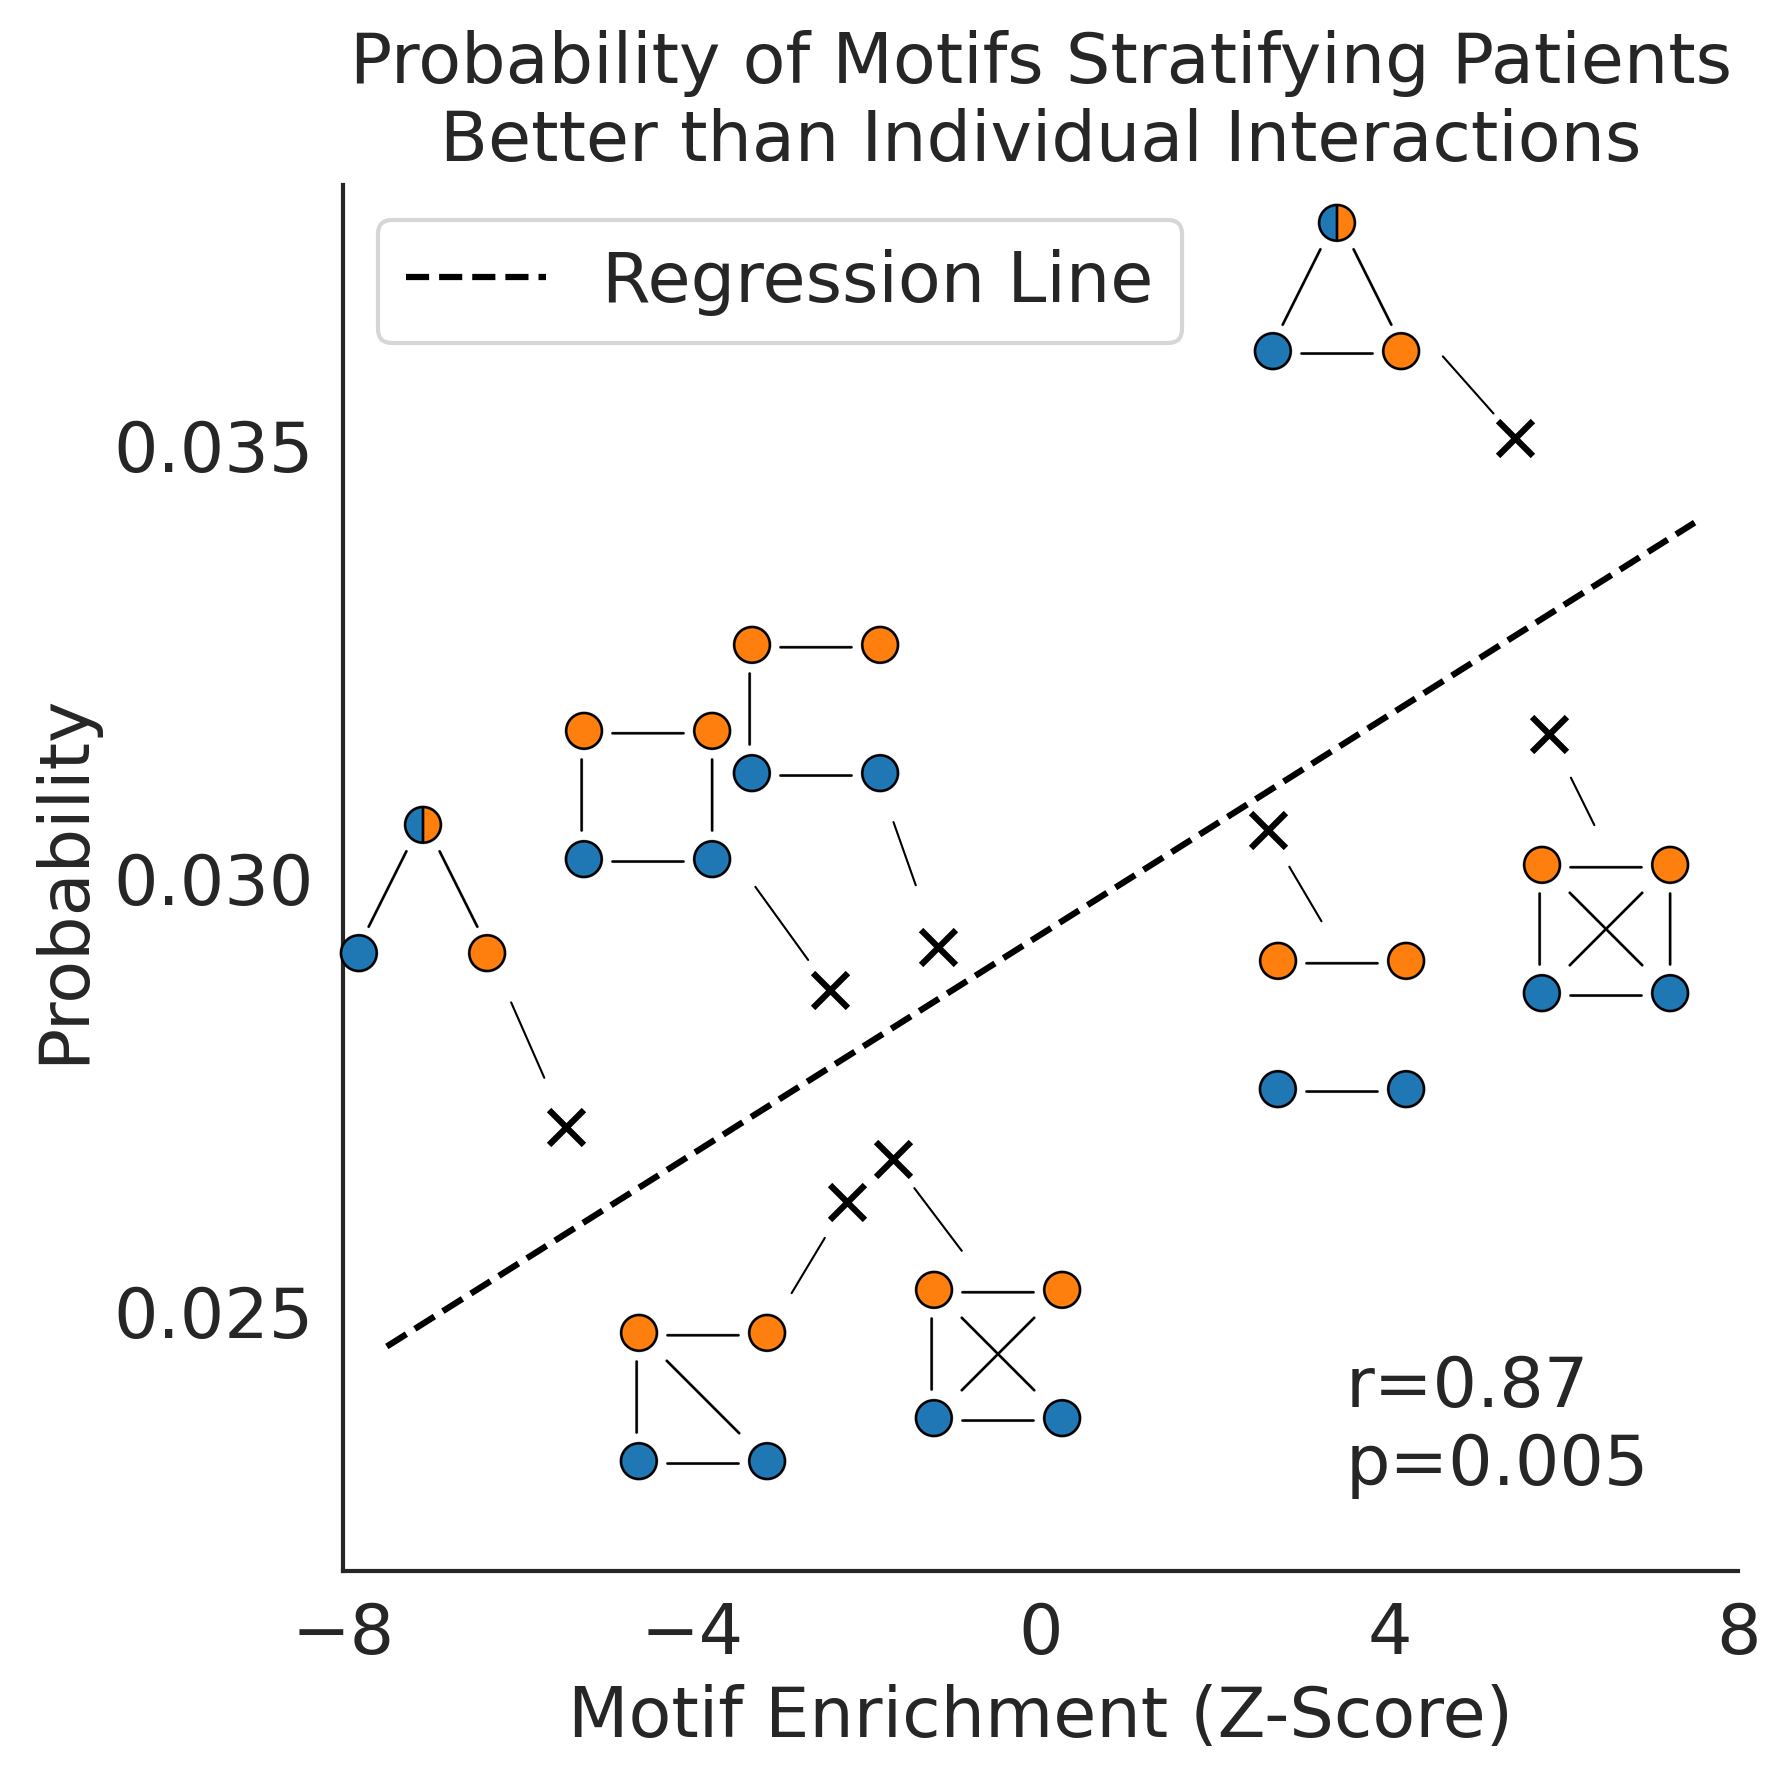

In [11]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import image as mpimg
import os
from PIL import Image

# Constants
dpi = 300
img_dir = '/home/lnemati/pathway_crosstalk/data/motifs_icons/'  # Update this path
image_scaling_factor = 0.3  # Adjust this factor to scale image size (smaller = more zoomed out)
x_offset = -25
y_offset = 250

fs = 14/5 * 6

# Filter data
df = better.query('tissue != "Pan_Cancer"')
all_counts = crosstalkdf.query('tissue != "Pan_Cancer"').motif.value_counts().sort_values(ascending=False)

# Calculate probabilities
probs = (df.motif.value_counts() / all_counts).sort_values()
probs = probs.loc[motifs_z.index]

data = pd.DataFrame()
data['z'] = motifs_z
data['prob'] = probs

# Calculate Pearson correlation
r_value, p_r_value = pearsonr(probs, motifs_z)
rho_value, p_rho_value = spearmanr(probs, motifs_z)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=dpi)

# Plot the scatter points
#ax.scatter(
#    data['z'], 
#    data['prob'], 
#    color=lightgray, 
#    marker='s', 
#    edgecolors='black',  # Black edge color
#    s=70,
#    linewidths=1.5  # Thickness of the edge
#)
ax.scatter(
    data['z'], 
    data['prob'], 
    #color='black', 
    color='black', 
    marker='x', 
    edgecolors='black',  # Black edge color
    s=70,
    linewidths=1.5  # Thickness of the edge
)

# Add Pearson correlation to plot
ax.text(3.5, 0.023, 'r={:.2f}\np={:.3f}'.format(r_value, p_r_value), fontsize=fs)
#ax.text(7, 0.0225, fr"Spearman's $\rho$ = {rho_value:.2f}" + '\n' + f'p-value = {p_rho_value:.2f}', fontsize=fs, ha='right')

# Set limits and ticks
ax.set_xlim(-8, 8)
ax.set_ylim(0.022, 0.038)
xticks = [-8, -4, 0, 4, 8]
yticks = [0.025, 0.030, 0.035]
ax.set_xticks(xticks)
ax.set_yticks(yticks)

# Hide top and right spines
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=fs)

# Add title and labels
ax.set_title('Probability of Motifs Stratifying Patients\nBetter than Individual Interactions', fontsize=fs)
ax.set_xlabel('Motif Enrichment (Z-Score)', fontsize=fs)
ax.set_ylabel('Probability', fontsize=fs)

# Make the background of the plot transparent so the images can show up
ax.patch.set_alpha(0)

# Get the regression line parameters (slope and intercept)
slope, intercept = np.polyfit(data['z'], data['prob'], 1)

# Extend the regression line beyond the data range
x_extended = np.linspace(ax.get_xlim()[0] + 0.5, ax.get_xlim()[1] - 0.5, 100)
y_extended = slope * x_extended + intercept
ax.plot(x_extended, y_extended, linestyle='--', color='k', linewidth=1.5, label='Regression Line', zorder=-10)

# Dictionary to define manual positions for each motif
motif_positions = {
    '3_path': (data['z']['3_path'], data['prob']['3_path']),
    '4_cycle': (data['z']['4_cycle']-0.45, data['prob']['4_cycle']-0.0005),
    '4_triangle_extra': (data['z']['4_triangle_extra'], data['prob']['4_triangle_extra']-0.005),
    '4_one_missing': (data['z']['4_one_missing']+2.85, data['prob']['4_one_missing']-0.005),
    '4_path': (data['z']['4_path']+0.25, data['prob']['4_path']),
    '4_no_crosstalk': (data['z']['4_no_crosstalk']+2.5, data['prob']['4_no_crosstalk']-0.005),
    '3_clique': (data['z']['3_clique']-0.4, data['prob']['3_clique']-0.001),
    '4_clique': (data['z']['4_clique']+2.3, data['prob']['4_clique']-0.005),
}

# Loop through each motif and place an image at the manually defined position
for motif, (x_pos, y_pos) in motif_positions.items():
    img_path = os.path.join(img_dir, f"{motif}.png")
    if os.path.exists(img_path):
        # Read image
        im = Image.open(img_path)
        
        # Resize the image (scale it down by the factor)
        width, height = im.size
        im_resized = im.resize((int(width * image_scaling_factor), int(height * image_scaling_factor)))

        # Convert resized image to numpy array for figimage
        im_resized = np.array(im_resized)

        # Transform plot coordinates to pixel coordinates
        pixel_pos = ax.transData.transform((x_pos, y_pos))
        
        # Place image at position (centered over the point) with scaled size
        fig.figimage(
            im_resized,
            pixel_pos[0] - im_resized.shape[1] / 2 + x_offset,
            pixel_pos[1] - im_resized.shape[0] / 2 + y_offset, 
            origin="upper"
        )

        line_frac = 0.5  # Fraction to remove from the image (icon) side
        marker_trim = 0.25  # Fixed distance to trim from the marker side (in data units)

        # Compute image center in pixel space
        img_center_x_pix = pixel_pos[0] - im_resized.shape[1] / 2 + x_offset
        img_center_y_pix = pixel_pos[1] + y_offset

        # Convert image center from pixel to data coordinates
        img_center_data = ax.transData.inverted().transform((img_center_x_pix, img_center_y_pix))

        # Coordinates of the start (marker) and end (image) of the full line
        x0, y0 = motifs_z.loc[motif], probs.loc[motif]  # marker
        x1, y1 = img_center_data                        # image

        # Vector from marker to image
        dx = x1 - x0
        dy = y1 - y0
        line_length = np.hypot(dx, dy)

        # Normalize direction vector
        dxn, dyn = dx / line_length, dy / line_length

        # Remove a fixed-length segment from the marker side
        x_start = x0 + dxn * marker_trim
        y_start = y0 + dyn * marker_trim

        # Remove a *fraction* of the total line length from the image side
        x_end = x1 - dxn * (line_frac * line_length)
        y_end = y1 - dyn * (line_frac * line_length)

        # Draw the trimmed line
        ax.plot([x_start, x_end], [y_start, y_end], color='k', linewidth=0.5, zorder=-5)

# Hide legend, as it may conflict with the images
#plt.legend([], [], frameon=False)
plt.legend(fontsize=fs, loc='upper left')

#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/survival/motifs_z_prob.pdf', bbox_inches='tight', dpi=dpi)
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/survival/motifs_z_prob.png', bbox_inches='tight', dpi=dpi)

# Show the plot
plt.show()


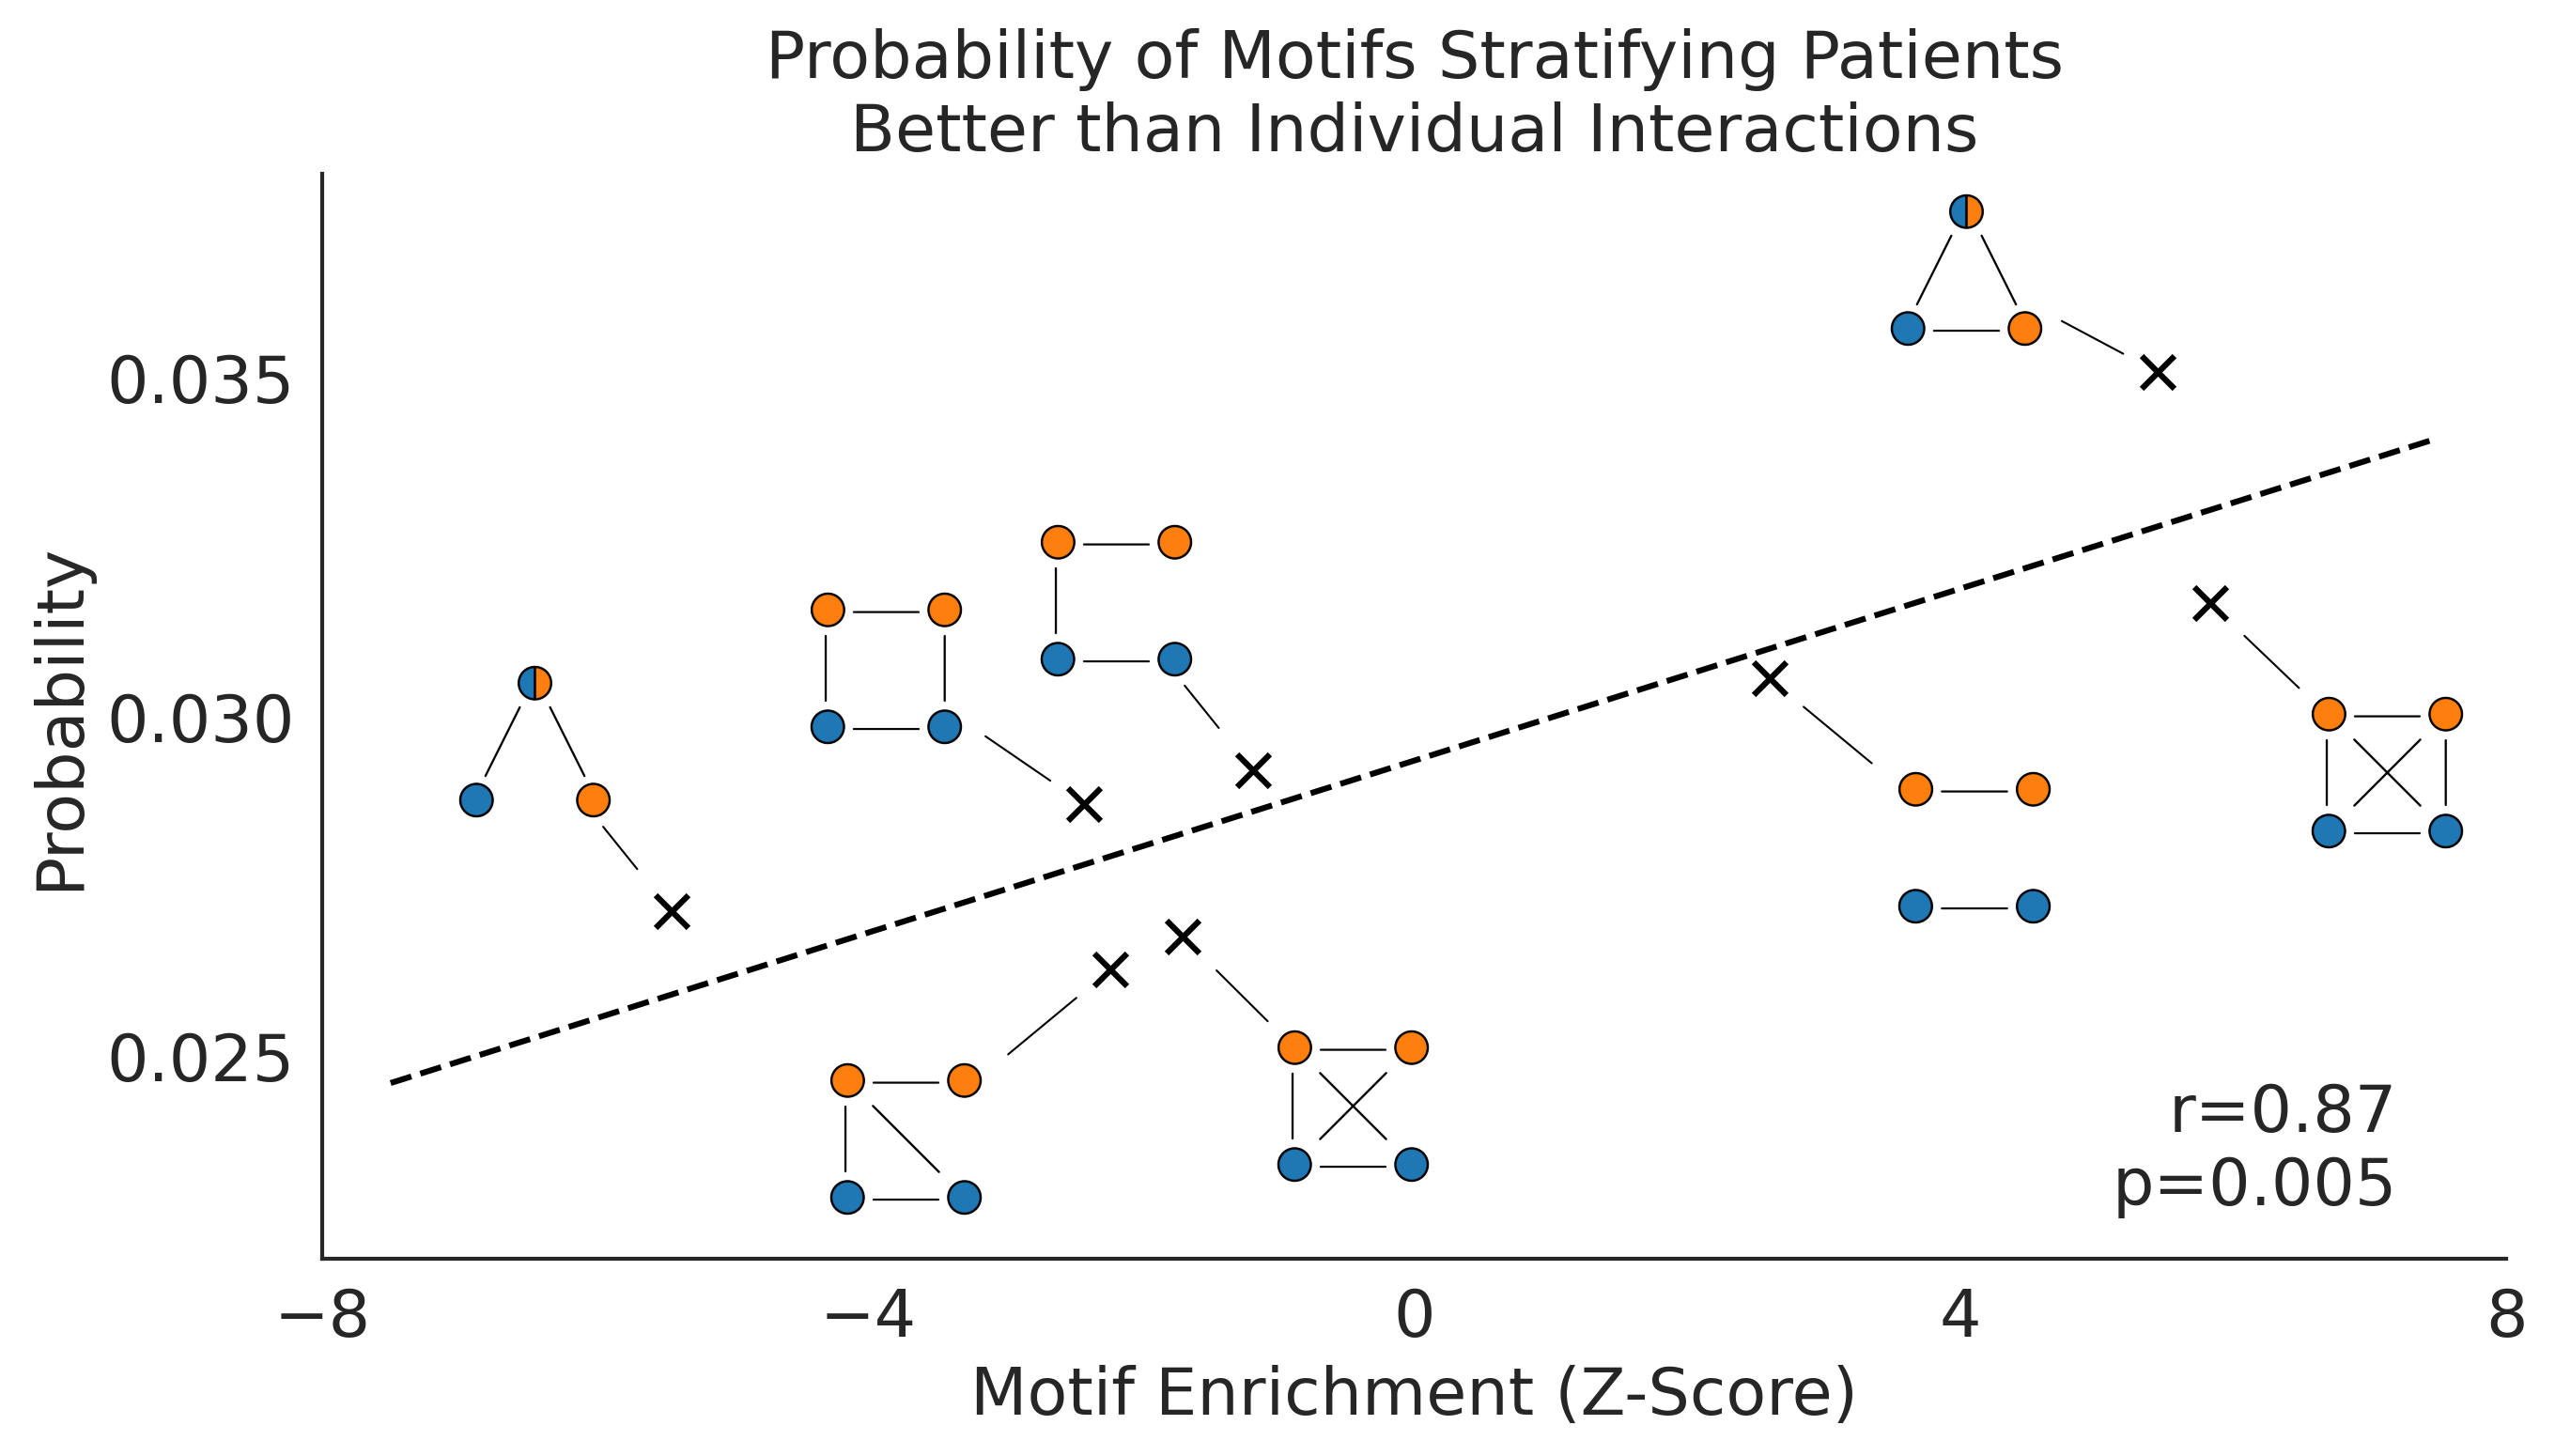

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from PIL import Image
import os
from scipy.stats import pearsonr, spearmanr

# --- Constants ---
dpi = 300
img_dir = '/home/lnemati/pathway_crosstalk/data/motifs_icons/'
image_scaling_factor = 0.55  # smaller for subplot usage
fs = 14 / 5 * 6

x_offset = -1
y_offset = 0.0025

# --- Filter Data ---
df = better.query('tissue != "Pan_Cancer"')
all_counts = crosstalkdf.query('tissue != "Pan_Cancer"').motif.value_counts().sort_values(ascending=False)
probs = (df.motif.value_counts() / all_counts).sort_values()
probs = probs.loc[motifs_z.index]

data = pd.DataFrame({'z': motifs_z, 'prob': probs})

# --- Correlation ---
r_value, p_r_value = pearsonr(probs, motifs_z)
rho_value, p_rho_value = spearmanr(probs, motifs_z)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 5), dpi=dpi)

# Scatter
ax.scatter(data['z'], data['prob'], color='black', marker='x', s=70, linewidths=1.5)

# Correlation text
ax.text(0.95, 0.05, f'r={r_value:.2f}\np={p_r_value:.3f}',
        transform=ax.transAxes, fontsize=fs, ha='right')

# Axes settings
ax.set_xlim(-8, 8)
ax.set_ylim(0.022, 0.038)
ax.set_xticks([-8, -4, 0, 4, 8])
ax.set_yticks([0.025, 0.030, 0.035])
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=fs)
ax.set_title('Probability of Motifs Stratifying Patients\nBetter than Individual Interactions', fontsize=fs)
ax.set_xlabel('Motif Enrichment (Z-Score)', fontsize=fs)
ax.set_ylabel('Probability', fontsize=fs)

# Regression line
slope, intercept = np.polyfit(data['z'], data['prob'], 1)
x_extended = np.linspace(ax.get_xlim()[0] + 0.5, ax.get_xlim()[1] - 0.5, 100)
y_extended = slope * x_extended + intercept
ax.plot(x_extended, y_extended, linestyle='--', color='k', linewidth=1.5, zorder=-10)

motif_positions = {
    '3_path': (data['z']['3_path'], data['prob']['3_path']),
    '4_cycle': (data['z']['4_cycle'] - 0.45, data['prob']['4_cycle'] - 0.0005),
    '4_triangle_extra': (data['z']['4_triangle_extra']-0.5, data['prob']['4_triangle_extra'] - 0.005),
    '4_one_missing': (data['z']['4_one_missing'] + 2.25, data['prob']['4_one_missing'] - 0.005),
    '4_path': (data['z']['4_path'], data['prob']['4_path']),
    '4_no_crosstalk': (data['z']['4_no_crosstalk'] + 2.5, data['prob']['4_no_crosstalk'] - 0.005),
    '3_clique': (data['z']['3_clique'] - 0.4, data['prob']['3_clique'] - 0.001),
    '4_clique': (data['z']['4_clique'] + 2.3, data['prob']['4_clique'] - 0.005),
}

#motif_positions = {k: (data['z'][k], data['prob'][k]) for k in data.index}

# --- Add motif icons using inset_axes ---
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

for motif, (x_pos, y_pos) in motif_positions.items():
    img_path = os.path.join(img_dir, f"{motif}.png")
    x_pos += x_offset
    y_pos += y_offset
    if os.path.exists(img_path):
        # Convert data coordinates to axis-relative
        inv = ax.transData.transform
        trans = ax.transAxes.inverted().transform
        ax_rel_coords = trans(inv((x_pos, y_pos)))

        # Create inset axes at that location
        ax_img = inset_axes(ax,
                            width=image_scaling_factor,
                            height=image_scaling_factor,
                            loc='center',
                            bbox_to_anchor=(ax_rel_coords[0], ax_rel_coords[1]),
                            bbox_transform=ax.transAxes,
                            borderpad=0)

        # Load and show image
        im = Image.open(img_path)
        ax_img.imshow(im)
        ax_img.axis('off')

        # Line from data point to image center
        x0, y0 = data['z'][motif], data['prob'][motif]  # data point
        x1, y1 = x_pos, y_pos  # image anchor
        dx, dy = x1 - x0, y1 - y0
        length = np.hypot(dx, dy)
        line_frac = 0.5
        marker_trim = 0.25
        dxn, dyn = dx / length, dy / length
        x_start, y_start = x0 + dxn * marker_trim, y0 + dyn * marker_trim
        x_end, y_end = x1 - dxn * (line_frac * length), y1 - dyn * (line_frac * length)
        ax.plot([x_start, x_end], [y_start, y_end], color='k', linewidth=0.5, zorder=-5)

# Legend (optional, usually omitted for clarity)
# ax.legend(fontsize=fs, loc='upper left')

# Save
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/survival/motifs_z_prob_large.pdf', bbox_inches='tight', dpi=dpi)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/survival/motifs_z_prob_large.png', bbox_inches='tight', dpi=dpi)

plt.show()


# Barplot By Rank Aggregate of C Index and HR Increase

In [13]:
# Filter for desired motifs
barplotdf = better.query('motif in ["3_clique", "4_clique"]').copy()

# Compute ranks within each tissue (lower rank = better)
barplotdf['cindex_rank'] = barplotdf.groupby('tissue')['concordance_index'].rank(ascending=False)
barplotdf['hrlfc_rank'] = barplotdf.groupby('tissue')['hr_lfc_best'].rank(ascending=False)

# Combine the ranks (simple sum — you can customize this)
barplotdf['agg_rank'] = barplotdf['cindex_rank'] + barplotdf['hrlfc_rank']

# Get top 3 by aggregate rank per tissue
barplotdf = barplotdf.sort_values(by='agg_rank').groupby('tissue').head(3)

# Drop Pan_Cancer and clean tissue labels
barplotdf = barplotdf.query('tissue != "Pan_Cancer"')
barplotdf['tissue'] = barplotdf['tissue'].str.replace('_', ' ').str.replace(' And ', ' & ')

for idx, row in barplotdf.iterrows():
    # First interaction must be the closest to zero
    if np.abs(row['log2_hr1']) > np.abs(row['log2_hr2']):
        # reorder values
        val1, val2 = (row['log2_hr1'], row['log2_hr2'])
        barplotdf.at[idx, 'log2_hr1'] = val2
        barplotdf.at[idx, 'log2_hr2'] = val1
        # reorder name
        int1, int2 = row['interaction'].split('&')
        barplotdf.at[idx, 'interaction'] = int2 + '&' + int1
        
barplotdf['interaction'] = barplotdf.interaction.str.replace('_', ' - ').str.replace('+', ' - ').str.replace('&', ' & ')

In [ ]:
import re

# Split interactions into individual genes for each side
barplotdf['interaction1'] = barplotdf.interaction.apply(lambda x: re.split('&', x)[0].strip().split(' - '))
barplotdf['interaction2'] = barplotdf.interaction.apply(lambda x: re.split('&', x)[1].strip().split(' - '))

# Load hallmark gene sets
def read_gmt(file_path):
    gene_sets = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                gene_sets[parts[0]] = set(parts[2:])
    return gene_sets

hallmarks_path = '/home/lnemati/resources/msigdb_hallmarks/h.all.v2024.1.Hs.symbols.gmt'
hallmarks = read_gmt(hallmarks_path)

# Generate cleaned hallmark labels
labels = [label.replace('HALLMARK_', '').replace('_', ' ').title() for label in hallmarks.keys()]

replace = {
    'Myc': 'MYC',
    'Kras': 'KRAS',
    'Il2': 'IL2',
    'Stat5': 'STAT5',
    'Il6': 'IL6',
    'Jak': 'JAK',
    'Stat3': 'STAT3',
    'P53': 'P53',
    'Tnfa': 'TNFα',
    'Nfkb': 'NF-κB',
    'Mtorc1': 'mTORC1',
    'Mtorc': 'mTORC',
    'Mtor': 'mTOR',
    ' Dn': ' Down',
    'Pi3K': 'PI3K',
    ' Akt': ' AKT',
    'Epithelial Mesenchymal Transition': 'E-M Transition'
}

for str1, str2 in replace.items():
    labels = [label.replace(str1, str2) for label in labels]

hallmark_name_map = dict(zip(hallmarks.keys(), labels))

# Function to find matching hallmark sets for a given gene list
def find_matching_hallmarks(gene_list, hallmark_sets):
    return [name for name, genes in hallmark_sets.items() if set(gene_list) & genes]

# Get hallmarks for each side of the interaction
barplotdf['hallmarks1'] = barplotdf['interaction1'].apply(lambda genes: find_matching_hallmarks(genes, hallmarks))
barplotdf['hallmarks2'] = barplotdf['interaction2'].apply(lambda genes: find_matching_hallmarks(genes, hallmarks))

# Convert to readable labels using the name map
barplotdf['hallmarks1'] = barplotdf['hallmarks1'].apply(lambda hlist: [hallmark_name_map[h] for h in hlist])
barplotdf['hallmarks2'] = barplotdf['hallmarks2'].apply(lambda hlist: [hallmark_name_map[h] for h in hlist])

import numpy as np

# Define subset of hallmarks you want to consider (for example, top N or all unique found)
# For demonstration, use all unique hallmarks found across both sides:
all_hallmarks = sorted(set(sum(barplotdf['hallmarks1'], [])) | set(sum(barplotdf['hallmarks2'], [])))

# Initialize matrix: rows = interactions, columns = hallmarks
heatmap_matrix = np.zeros((len(barplotdf), len(all_hallmarks)), dtype=int)

# Fill matrix with presence codes
for i, row in enumerate(barplotdf.itertuples(index=False)):
    hallmarks_1 = set(row.hallmarks1)
    hallmarks_2 = set(row.hallmarks2)
    for j, hallmark in enumerate(all_hallmarks):
        in_1 = hallmark in hallmarks_1
        in_2 = hallmark in hallmarks_2
        heatmap_matrix[i, j] = 1 * in_1 + 2 * in_2  # 0, 1, 2, or 3

heatmap_df = pd.DataFrame(heatmap_matrix, index=barplotdf.interaction, columns=all_hallmarks)    
heatmap_df = heatmap_df[::-1] # Invert to match order of the plot

# Values:
# 0 = not present
# 1 = interaction1
# 2 = interaction2
# 3 = both interactions


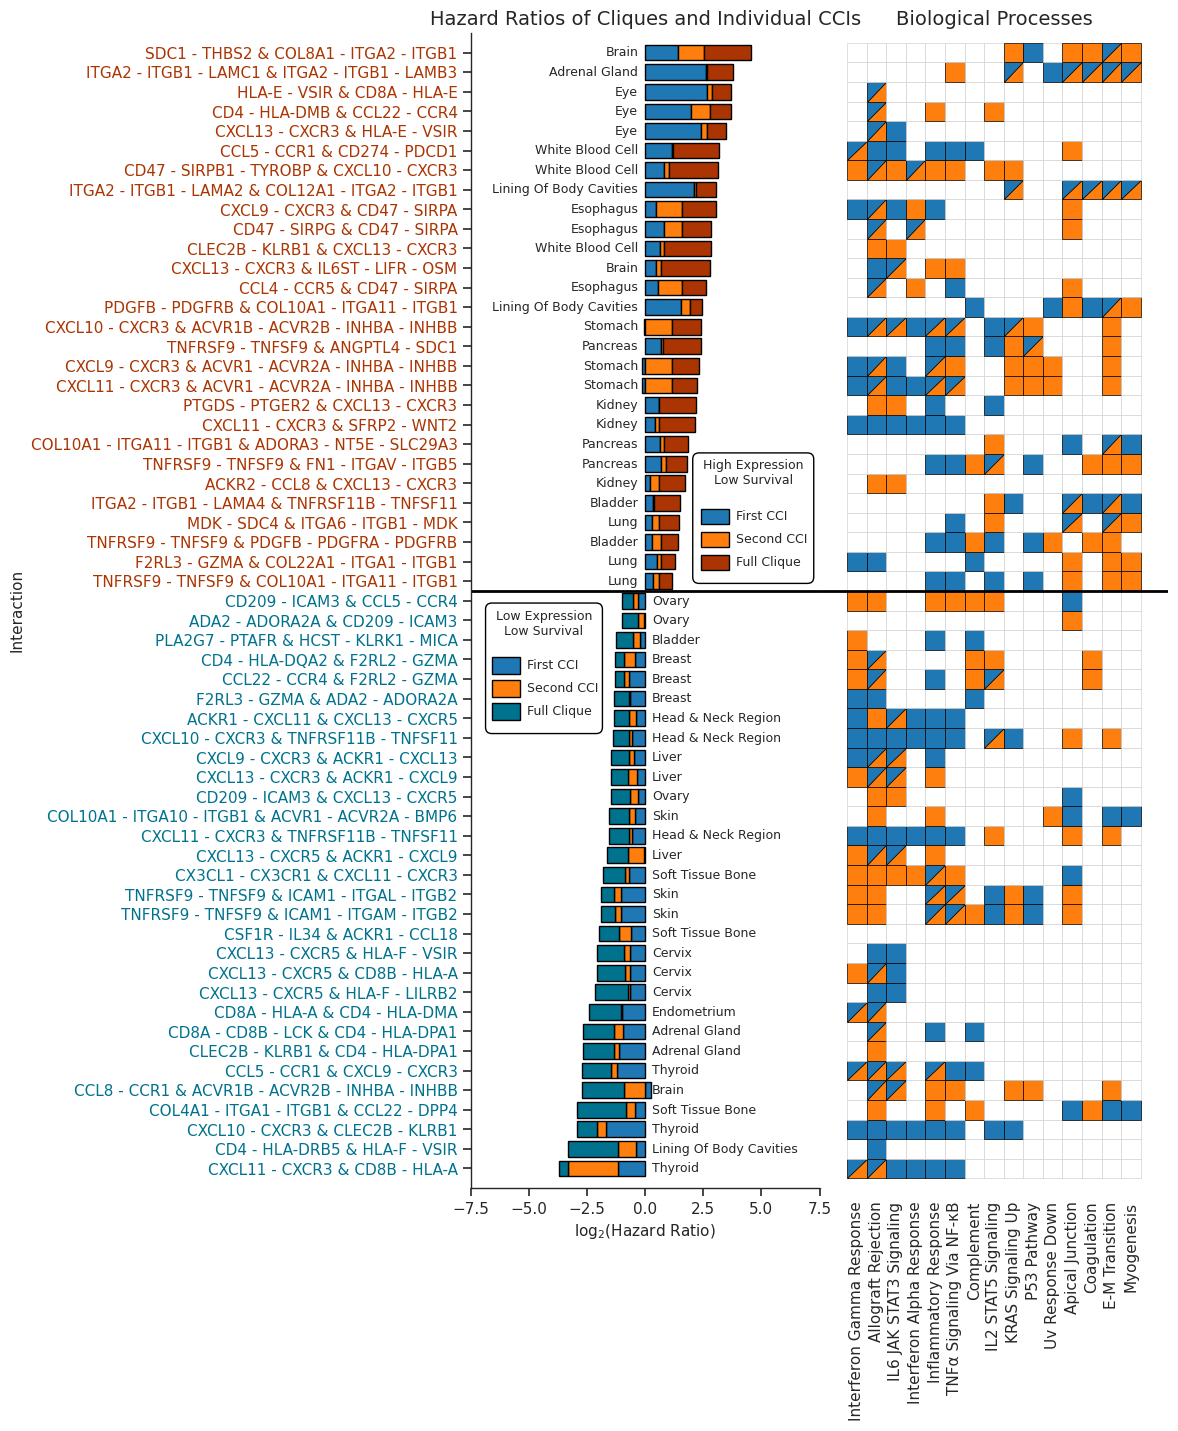

In [97]:
import matplotlib.patches as patches
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.colors as mcolors

titlefs=14
fs = 11
smallfs = 9
height = 0.8
N = 15  # number of hallmarks to select

CLUSTER = True  # Set to True if you want to cluster the heatmap

# Count how many interactions have each hallmark (non-zero values)
hallmark_counts = (heatmap_df != 0).sum(axis=0)

# Select top N hallmarks by count
top_hallmarks = hallmark_counts.sort_values(ascending=False).head(N).index
top_heatmap_df = heatmap_df[top_hallmarks]

# Optional: replace all non-zero values with 1 and cluster columns (processes)
if CLUSTER:
    binary_heatmap_df = top_heatmap_df.copy()
    binary_heatmap_df[binary_heatmap_df > 0] = 1
    # Cluster columns using scipy
    from scipy.cluster.hierarchy import linkage, leaves_list
    from scipy.spatial.distance import squareform
    from scipy.cluster.hierarchy import dendrogram
    # Compute linkage matrix
    Z = linkage(squareform(1 - binary_heatmap_df.corr()), method='average')
    # Get the order of columns based on clustering
    cluster_order = leaves_list(Z)
    # Reorder columns in top_heatmap_df
    top_heatmap_df = top_heatmap_df.iloc[:, cluster_order]

# Sort barplotdf by log2_hr ascending and get y positions
barplotdf = barplotdf.sort_values(by='log2_hr', ascending=True)
y_pos = np.arange(len(barplotdf))

# Use your top_heatmap_df from earlier (rows = interactions, cols = top hallmarks)
# Make sure it aligns with barplotdf index order
top_heatmap_df = top_heatmap_df.loc[barplotdf['interaction']]

# Prepare the matrix for imshow
hallmark_matrix = top_heatmap_df.values

# Define colors: white (0), blue (1), orange (2), purple (3)
#colors = ['white', 'C0', 'C1', 'purple']
#cmap = mcolors.ListedColormap(colors)
#bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
#norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create figure and gridspec with adjusted width ratios
fig = plt.figure(figsize=(9, 15))  # Increased width overall for more room
gs = gridspec.GridSpec(1, 2, width_ratios=[1., 1], wspace=0)  # Give more room to heatmap
ax = fig.add_subplot(gs[0])
ax_hm = fig.add_subplot(gs[1])

# Plot barplot (same as your original code)
for j, (i, row) in enumerate(barplotdf.iterrows()):
    ypos = y_pos[j]
    hr1 = row['log2_hr1']
    hr2 = row['log2_hr2']
    hr = row['log2_hr']

    if hr1 != 0:
        ax.barh(ypos, hr1, color='C0', height=height, edgecolor='k', linewidth=1)

    if hr1 * hr2 < 0:
        left2 = 0
        width2 = hr2
    else:
        left2 = hr1
        width2 = hr2 - hr1
    ax.barh(ypos, width2, left=left2, color='C1', height=height, edgecolor='k', linewidth=1)

    width3 = hr - hr2
    color = tcolor if hr > 0 else ncolor
    if width3 != 0:
        ax.barh(ypos, width3, left=hr2, color=color, height=height, edgecolor='k', linewidth=1)

# Tissue labels
for j, row in enumerate(barplotdf.itertuples()):
    ypos = y_pos[j]
    tissue = row.tissue
    hr = row.log2_hr
    if hr >= 0:
        ax.text(-0.3, ypos, tissue, va='center', ha='right', fontsize=smallfs)
    else:
        ax.text(0.3, ypos, tissue, va='center', ha='left', fontsize=smallfs)

# Axis settings
ax.set_yticks(y_pos)
ax.set_yticklabels(barplotdf['interaction'], fontsize=fs)
ax.invert_yaxis()
ax.set_xlabel('log$_2$(Hazard Ratio)', fontsize=fs)
ax.set_ylabel('Interaction', fontsize=fs)
ax.set_ylim(-1, len(barplotdf))
ax.tick_params(axis='x', labelsize=fs)
ax.set_xlim(-7.5, 7.5)

N_neg = sum(barplotdf['log2_hr'] < 0)
ax.axhline(N_neg - 0.5, color='black', linewidth=2, linestyle='-')

y_labels = ax.get_yticklabels()
for i, label in enumerate(y_labels):
    label.set_color(ncolor if i < N_neg else tcolor)

# Remove spines
for spine in ax_hm.spines.values():
    spine.set_visible(False)

# Heatmap axis tweaks:
ax_hm.clear()
ax_hm.set_yticks([])  # Hide y ticks
ax_hm.tick_params(axis='x', which='both', bottom=True, top=False, length=6, width=1.2)
ax_hm.tick_params(axis='y', which='both', bottom=True, top=False, length=6, width=1.2)

# Major ticks centered
ax_hm.set_xticks(np.arange(len(top_heatmap_df.columns)) + 0.5)
ax_hm.set_xticklabels(top_heatmap_df.columns, rotation=90, fontsize=fs)

# Minor ticks on edges for grid
ax_hm.set_xticks(np.arange(len(top_heatmap_df.columns)+1), minor=True)
ax_hm.set_yticks(np.arange(hallmark_matrix.shape[0]+1)-0.5, minor=True)

ax_hm.grid(which='minor', color='white', linewidth=2.5)
ax_hm.tick_params(which='minor', bottom=False, left=False, length=6, width=1.2)

# Draw squares and triangles
cell_height = 1
cell_width = 1
for row_idx in range(hallmark_matrix.shape[0]):
    for col_idx in range(hallmark_matrix.shape[1]):
        val = hallmark_matrix[row_idx, col_idx]
        y = row_idx
        x = col_idx

        if val == 0:
            rect = patches.Rectangle((x, y), cell_width, cell_height, facecolor='white', edgecolor='lightgray', linewidth=0.5)
            ax_hm.add_patch(rect)
        elif val == 1:
            rect = patches.Rectangle((x, y), cell_width, cell_height, facecolor='C0', edgecolor='k', linewidth=0.5)
            ax_hm.add_patch(rect)
        elif val == 2:
            rect = patches.Rectangle((x, y), cell_width, cell_height, facecolor='C1', edgecolor='k', linewidth=0.5)
            ax_hm.add_patch(rect)
        elif val == 3:
            xy = [(x, y), (x + cell_width, y), (x + cell_width, y + cell_height), (x, y + cell_height)]
            tri1 = patches.Polygon([xy[0], xy[3], xy[2]], facecolor='C0', edgecolor='k', linewidth=0.5)
            tri2 = patches.Polygon([xy[0], xy[1], xy[2]], facecolor='C1', edgecolor='k', linewidth=0.5)
            ax_hm.add_patch(tri1)
            ax_hm.add_patch(tri2)

ax_hm.set_xlim(0, hallmark_matrix.shape[1])
ax_hm.set_ylim(-0.5, hallmark_matrix.shape[0]+0.5)

# **Make cells square and prevent cropping**
ax_hm.set_aspect('equal', adjustable='datalim')  # Make squares

# Labels
props = dict(boxstyle='round,pad=0.5', facecolor='none', edgecolor='black', linewidth=1)
ax.text(0.81, 0.58, ' High Expression \nLow Survival\n\n\n\n\n\n', ha='center', va='center', fontsize=smallfs, transform=ax.transAxes, bbox=props)
ax.text(0.21, 0.45, ' Low Expression \nLow Survival\n\n\n\n\n\n', ha='center', va='center', fontsize=smallfs, transform=ax.transAxes, bbox=props)

# Legend for high expression box
legend_x, legend_y = 0.66, 0.575
width, height = 0.08, 0.013
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor='C0', edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'First CCI', transform=ax.transAxes,
        va='center', fontsize=smallfs)

legend_y -= 0.02
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor='C1', edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'Second CCI', transform=ax.transAxes,
        va='center', fontsize=smallfs)

legend_y -= 0.02
color = tcolor  # or ncolor if you want to differentiate
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor=color, edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'Full Clique', transform=ax.transAxes,
        va='center', fontsize=smallfs)


# Legend for low expression box
legend_x, legend_y = 0.06, 0.445
width, height = 0.08, 0.015
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor='C0', edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'First CCI', transform=ax.transAxes,
        va='center', fontsize=smallfs)

legend_y -= 0.02
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor='C1', edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'Second CCI', transform=ax.transAxes,
        va='center', fontsize=smallfs)

legend_y -= 0.02
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor=ncolor, edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'Full Clique', transform=ax.transAxes,
        va='center', fontsize=smallfs)

# Add horizontal line to heatmap matching the barplot
ax_hm.axhline(N_neg, color='black', linewidth=2, linestyle='-')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Hazard Ratios of Cliques and Individual CCIs', fontsize=titlefs)
ax_hm.set_title('Biological Processes', fontsize=titlefs)

ax.tick_params(bottom=True, top=False, left=True, labelbottom=True, length=6, width=1.2)
ax_hm.tick_params(bottom=False, top=False, left=False, labelbottom=True, length=6, width=1.2)

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/survival/hr_barplot_clustered.pdf', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/survival/hr_barplot_clustered.png', bbox_inches='tight', dpi=300)

plt.show()

In [ ]:
# SAVE CROSSTALKDF WITH HALLAMRKS

dataframe = better.copy()

import re

# Split interactions into individual genes for each side
dataframe['interaction1'] = dataframe.interaction.apply(lambda x: re.split('&', x)[0].strip())
dataframe['interaction1'] = dataframe['interaction1'].apply(lambda x: re.split(r'[+_]', x))
dataframe['interaction2'] = dataframe.interaction.apply(lambda x: re.split('&', x)[1].strip())
dataframe['interaction2'] = dataframe['interaction2'].apply(lambda x: re.split(r'[+_]', x))

# Load hallmark gene sets
def read_gmt(file_path):
    gene_sets = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                gene_sets[parts[0]] = set(parts[2:])
    return gene_sets

hallmarks_path = '/home/lnemati/resources/msigdb_hallmarks/h.all.v2024.1.Hs.symbols.gmt'
hallmarks = read_gmt(hallmarks_path)

# Function to find matching hallmark sets for a given gene list
def find_matching_hallmarks(gene_list, hallmark_sets):
    return [name for name, genes in hallmark_sets.items() if set(gene_list) & genes]

# Get hallmarks for each side of the interaction
dataframe['hallmarks1'] = dataframe['interaction1'].apply(lambda genes: find_matching_hallmarks(genes, hallmarks))
dataframe['hallmarks2'] = dataframe['interaction2'].apply(lambda genes: find_matching_hallmarks(genes, hallmarks))

# Convert to readable labels using the name map
#dataframe['hallmarks1'] = dataframe['hallmarks1'].apply(lambda hlist: [hallmark_name_map[h] for h in hlist])
#dataframe['hallmarks2'] = dataframe['hallmarks2'].apply(lambda hlist: [hallmark_name_map[h] for h in hlist])

dataframe = dataframe.query('tissue != "Pan_Cancer" and motif in ["3_clique", "4_clique"]')

dataframe.to_csv('/home/lnemati/pathway_crosstalk/results/survival/cliques_better_with_processes.csv')


# Define subset of hallmarks you want to consider (for example, top N or all unique found)
# For demonstration, use all unique hallmarks found across both sides:
all_hallmarks = sorted(set(sum(barplotdf['hallmarks1'], [])) | set(sum(barplotdf['hallmarks2'], [])))

# Initialize matrix: rows = interactions, columns = hallmarks
heatmap_matrix = np.zeros((len(barplotdf), len(all_hallmarks)), dtype=int)

# Fill matrix with presence codes
for i, row in enumerate(barplotdf.itertuples(index=False)):
    hallmarks_1 = set(row.hallmarks1)
    hallmarks_2 = set(row.hallmarks2)
    for j, hallmark in enumerate(all_hallmarks):
        in_1 = hallmark in hallmarks_1
        in_2 = hallmark in hallmarks_2
        heatmap_matrix[i, j] = 1 * in_1 + 2 * in_2  # 0, 1, 2, or 3

heatmap_df = pd.DataFrame(heatmap_matrix, index=barplotdf.interaction, columns=all_hallmarks)    
heatmap_df = heatmap_df[::-1] # Invert to match order of the plot

In [103]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact

# Initialize storage for hallmark analysis
bad_counts = []
good_counts = []
log_odds_ratios = []
p_values = []

# Total number of bad and good prognosis cases
bad_total = dataframe.query('hr > 1').shape[0]
good_total = dataframe.query('hr < 1').shape[0]

# Loop through each hallmark
for hm in all_hallmarks:
    # a: hallmark in bad prognosis
    a = dataframe.query('hr > 1').apply(lambda x: hm in x.hallmarks1 or hm in x.hallmarks2, axis=1).sum()
    b = bad_total - a  # hallmark not in bad prognosis

    # c: hallmark in good prognosis
    c = dataframe.query('hr < 1').apply(lambda x: hm in x.hallmarks1 or hm in x.hallmarks2, axis=1).sum()
    d = good_total - c  # hallmark not in good prognosis

    # Store counts
    bad_counts.append(a)
    good_counts.append(c)

    # Fisher's exact test
    table = [[a, b], [c, d]]
    oddsratio, pvalue = fisher_exact(table)
    log_or = np.log2(oddsratio) if oddsratio > 0 else np.nan

    # Store test results
    log_odds_ratios.append(log_or)
    p_values.append(pvalue)

# Create the DataFrame
hallmark_summary = pd.DataFrame({
    'hallmark': all_hallmarks,
    'bad_prognosis_count': bad_counts,
    'good_prognosis_count': good_counts,
    'log_odds_ratio': log_odds_ratios,
    'p_value': p_values
})

# Also get probabilities not just counts
hallmark_summary['bad_prognosis_prob'] = hallmark_summary['bad_prognosis_count'] / bad_total
hallmark_summary['good_prognosis_prob'] = hallmark_summary['good_prognosis_count'] / good_total

# Optional: sort by significance or effect size
hallmark_summary = hallmark_summary.sort_values('p_value')

# Save the summary DataFrame
hallmark_summary.to_csv('/home/lnemati/pathway_crosstalk/results/survival/hallmarks_survival.csv', index=False)

# Multiple hypothesis testing
hallmark_summary['pval_adj'] = false_discovery_control(hallmark_summary['p_value'])

hallmark_summary['hallmark'] = hallmark_summary['hallmark'].str.replace('HALLMARK_', '').str.replace('_', ' ').str.title()

for str1, str2 in replace.items():
    hallmark_summary['hallmark'] = hallmark_summary['hallmark'].str.replace(str1, str2)

good_df = hallmark_summary.query('log_odds_ratio < 0').sort_values(by='good_prognosis_prob', ascending=False)
bad_df = hallmark_summary.query('log_odds_ratio > 0').sort_values(by='bad_prognosis_prob', ascending=False)

#good_df = hallmark_summary.query('pval_adj < 0.05 and log_odds_ratio < 0').sort_values(by='good_prognosis_prob', ascending=False)
#bad_df = hallmark_summary.query('pval_adj < 0.05 and log_odds_ratio > 0').sort_values(by='bad_prognosis_prob', ascending=False)

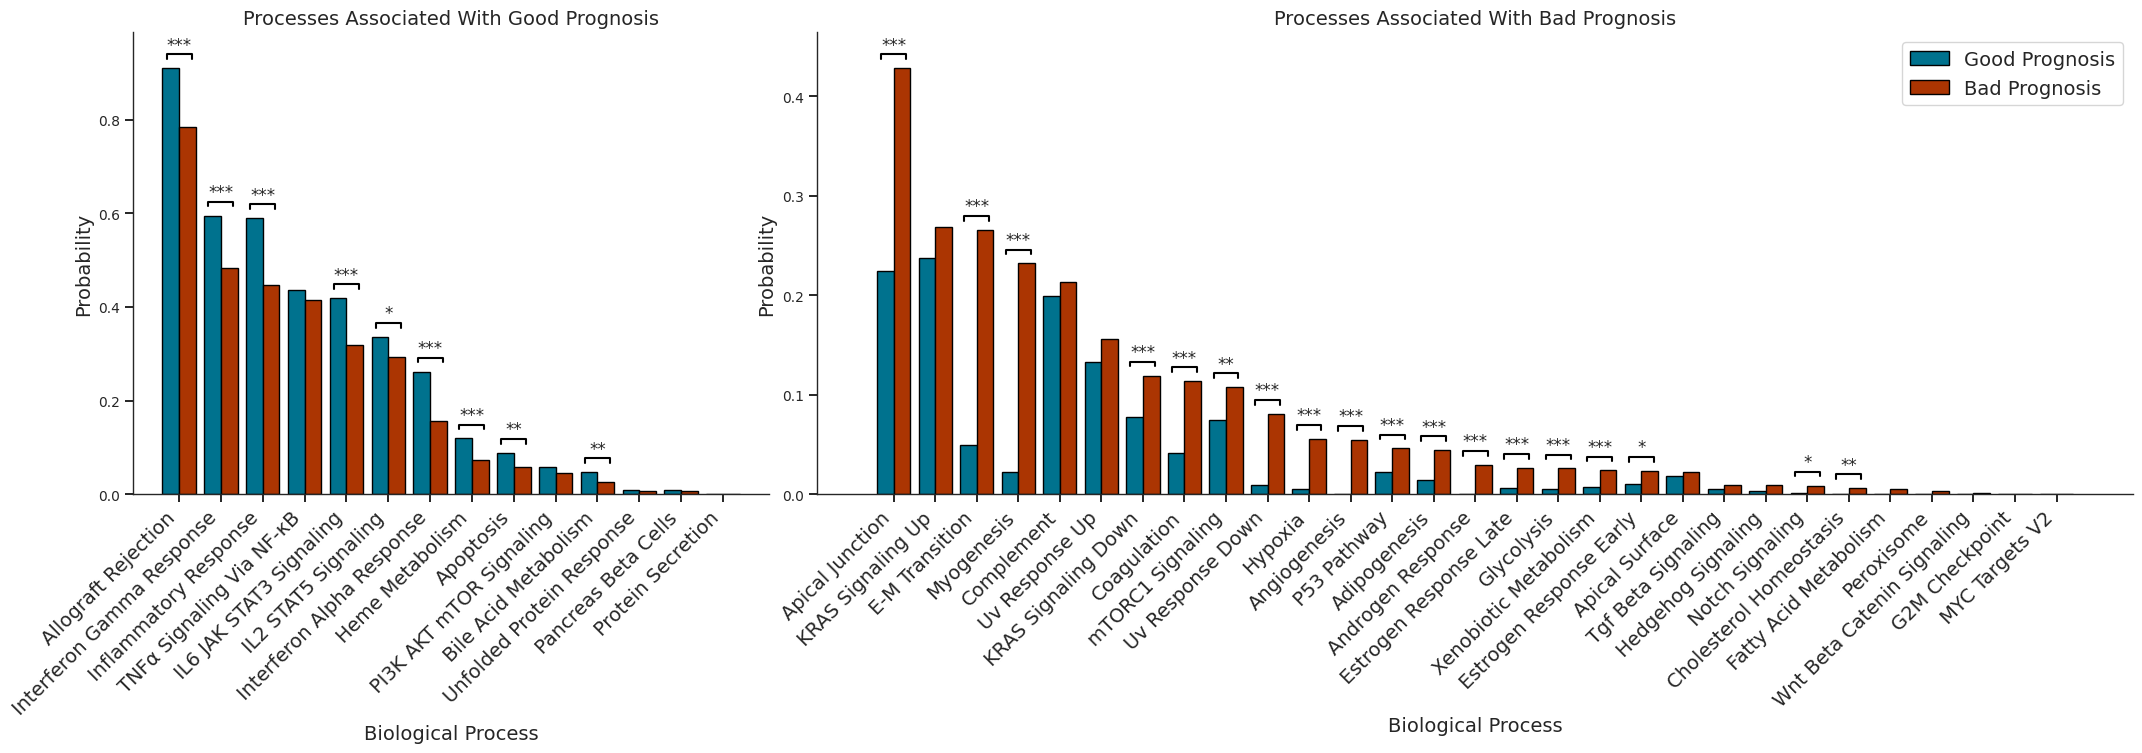

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# Constants
per_bar_width = 0.6  # width in inches per bar, tweak as needed
height = 6           # fixed figure height
fs = 14
smallfs = 11

# Function to plot one panel with vertical bars
def plot_panel(df, ax, title, color1, color2):
    hallmarks = df['hallmark']
    x_pos = np.arange(len(df))

    ax.bar(x_pos - 0.2, df['good_prognosis_prob'], width=0.4, color=color1, edgecolor='black', label='Good Prognosis')
    ax.bar(x_pos + 0.2, df['bad_prognosis_prob'], width=0.4, color=color2, edgecolor='black', label='Bad Prognosis')

    for i, row in df.iterrows():
        total_height = ax.get_ylim()[1] - ax.get_ylim()[0]
        x = x_pos[df.index.get_loc(i)]
        pval = row['pval_adj']
        stars = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
        if stars:
            max_prob = max(row['good_prognosis_prob'], row['bad_prognosis_prob'])
            ypos = max_prob + 0.02 * total_height
            h = 0.01 * total_height
            w = 0.3
            ax.plot([x - w, x - w, x + w, x + w], [ypos, ypos + h, ypos + h, ypos], color='black', linewidth=1.5)
            ax.text(x, max_prob + 4*h, stars, ha='center', fontsize=12)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(hallmarks, rotation=45, ha='right', fontsize=fs)
    ax.set_ylabel('Probability', fontsize=fs)
    ax.set_xlabel('Biological Process', fontsize=fs)
    ax.set_title(title, fontsize=fs)

    # Imposta che i tick siano mostrati
    ax.tick_params(
        axis='both',
        which='both',
        direction='out',
        length=6,
        width=1.2,
        color='black'
    )
    ax.xaxis.set_ticks_position('bottom')  # obbliga i tick sull’asse x
    ax.yaxis.set_ticks_position('left')    # obbliga i tick sull’asse y

    # Hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend
    ax.legend(fontsize=fs, loc='upper right')

# Calculate subplot widths
good_width = max(len(good_df) * per_bar_width, 2)  # min width 2 inches for readability
bad_width = max(len(bad_df) * per_bar_width, 2)

total_width = good_width + bad_width

fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    figsize=(total_width, height),
    gridspec_kw={'width_ratios': [good_width, bad_width]},
    sharey=False
)

plt.subplots_adjust(wspace=0.05)

# Plot both panels
plot_panel(good_df, ax1, 'Processes Associated With Good Prognosis', ncolor, tcolor)
plot_panel(bad_df, ax2, 'Processes Associated With Bad Prognosis', ncolor, tcolor)

# Remove legend from ax1
ax1.legend_.remove()

# Save the figure
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/survival/hallmarks_prognosis_all.pdf', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/survival/hallmarks_prognosis_all.png', bbox_inches='tight', dpi=300)

plt.show()


In [16]:
def survival(interactions, df):
    import pandas as pd
    from lifelines import KaplanMeierFitter
    import re   
    
    df = df.copy()
    
    # Extract genes from the interaction string
    genes = list(set(re.split(r'[+&_]', interactions)))

    # Check if there are multiple conditions
    multiple_conditions = len(df['condition'].unique()) > 1

    # Filter and process the DataFrame
    cols = ['OS.time', 'OS', 'condition'] + genes
    df = df[cols]

    # Convert columns to numeric, except for condition
    df.loc[:, [col for col in df.columns if col != 'condition']] = (
        df.loc[:, [col for col in df.columns if col != 'condition']].apply(pd.to_numeric, errors='coerce')
    )
    df = df.dropna()

    # Convert OS time to years
    df['OS.time'] = df['OS.time'] / 365

    high_expression_group = pd.DataFrame()
    low_expression_group = pd.DataFrame()

    if multiple_conditions:
        # If there are multiple conditions, split the patients based on each condition
        for condition in df['condition'].unique():
            condition_df = df[df['condition'] == condition]
            
            # Calculate medians for each gene within the condition
            medians = condition_df[genes].median()
            
            # Identify patients above/below the median for all genes
            high_expression = condition_df[(condition_df[genes] > medians).T.all()]
            low_expression = condition_df[(condition_df[genes] <= medians).T.all()]
            
            # Append to the respective groups
            high_expression_group = pd.concat([high_expression_group, high_expression])
            low_expression_group = pd.concat([low_expression_group, low_expression])
    else:
        # If there is only one condition, split based on the entire dataset
        medians = df[genes].median()
        high_expression_group = df[(df[genes] > medians).T.all()]
        low_expression_group = df[(df[genes] <= medians).T.all()]

    # Remove patients that are in both groups
    common_patients = high_expression_group.index.intersection(low_expression_group)
    high_expression_group = high_expression_group[~high_expression_group.index.isin(common_patients)]
    low_expression_group  = low_expression_group[ ~low_expression_group.index.isin( common_patients)]
        
    # Count number of patients
    n_patients_low = low_expression_group.shape[0]
    n_patients_high = high_expression_group.shape[0]

    # Fit the Kaplan-Meier estimators
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()

    kmf_low.fit(
        low_expression_group['OS.time'],
        event_observed=low_expression_group['OS'],
        label="Low Expr."
    )
    kmf_high.fit(
        high_expression_group['OS.time'],
        event_observed=high_expression_group['OS'],
        label="High Expr."
    )

    return {
        'name': interactions,
        'kmf_low': kmf_low,
        'kmf_high': kmf_high,
        'low_expression': low_expression_group.index,
        'high_expression': high_expression_group.index,
    }

In [17]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts
import matplotlib.patheffects as path_effects  # Import PathEffects for text outlines
from matplotlib.gridspec import GridSpec

def get_genes(string):
    genes = list(re.split(r'[+&_]', string))

    # Remove duplicates while preserving order
    seen = set()
    ordered_genes = []
    for gene in genes:
        if gene not in seen:
            seen.add(gene)
            ordered_genes.append(gene)

    return ordered_genes

def plot_all_3(interaction, tissue, survival_df, xlim=(0, 15), ylim=(0, 1.01), savepath=None, show=True):

    fs = 13
        
    df = survival_df.copy()
    # Change index from samples to patients
    df.index = df.index.str.rsplit(pat='-', n=1, expand=True).get_level_values(0) 
        
    #fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    #fig.suptitle(tissue.replace('_', ' ').title().replace(' And ', ' & '), fontsize=12, y=0.92)
    #plt.subplots_adjust(hspace=0.5)
    interaction_results = survival(interaction, df)
    
    fig = plt.figure(figsize=(10, 15))
    gs = GridSpec(3, 2, width_ratios=[1, 3], height_ratios=[1,1,1], figure=fig)

    axes = []
    for row in range(3):
        ax_box = fig.add_subplot(gs[row, 0])   # Boxplot on left, narrower
        ax_km = fig.add_subplot(gs[row, 1])    # Survival curve on right, wider
        axes.append((ax_box, ax_km))
    
    # 1st title
    title = tissue.replace('_', ' ').title().replace(' And ', ' & ') + ', '
    title += interaction.replace('&', ' & ').replace('+', ' - ').replace('_', ' - ')
    axes[0][1].set_title(title, fontsize=fs)
    
    # 2nd title
    title = tissue.replace('_', ' ').title().replace(' And ', ' & ') + ', '
    title += interaction.split('&')[0].replace('+', ' - ').replace('_', ' - ')
    axes[1][1].set_title(title, fontsize=fs)
    
    # 3rd title
    title = tissue.replace('_', ' ').title().replace(' And ', ' & ') + ', '
    title += interaction.split('&')[1].replace('+', ' - ').replace('_', ' - ')
    axes[2][1].set_title(title, fontsize=fs)
    
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    
    int1, int2 = interaction.split('&')
    interaction_results1 = survival(int1, df)
    interaction_results2 = survival(int2, df)

    # Plot the KM curves for both groups on the same plot
    for ax, result in zip(axes, (interaction_results, interaction_results1, interaction_results2)):
        name = result['name']
        genes = get_genes(name)
        
        pval = rawdf.set_index(['interaction', 'tissue']).loc[(name, tissue), 'logrank_pval']
        n_low = rawdf.set_index(['interaction', 'tissue']).loc[(name, tissue), 'n_patients_low']
        n_high = rawdf.set_index(['interaction', 'tissue']).loc[(name, tissue), 'n_patients_high']
        #pval = result['p_value']
        
        ax[1].set_xlim(xlim[0], xlim[1])
        ax[1].set_ylim(ylim[0], ylim[1])
        
        ci = False
        censors=True
        result['kmf_low'].plot_survival_function(
            ax=ax[1],
            color=ncolor,
            ci_show=ci,
            show_censors=censors,
            label='Low Expression, N={}'.format(n_low)
        )
        result['kmf_high'].plot_survival_function(
            ax=ax[1],
            color=tcolor,
            ci_show=ci,
            show_censors=censors,
            label='High Expression, N={}'.format(n_high)

        )
        
        add_at_risk_counts(result['kmf_low'], result['kmf_high'], ax=ax[1], ypos=-0.35, rows_to_show=['At risk'])
                
        ax[1].set_xlabel('Time (Years)', fontsize=fs)
        ax[1].set_ylabel('Survival Prob.', fontsize=fs)
        
        ax[1].legend(fontsize=fs, framealpha=0.5, loc='upper right')
        
        ypos = ax[1].get_ylim()[0] + 0.06*(ax[1].get_ylim()[1] - ax[1].get_ylim()[0])
        xpos = ax[1].get_xlim()[0] + 0.015*(ax[1].get_xlim()[1] - ax[1].get_xlim()[0])

        text = ax[1].text(xpos, ypos, '$p={:.1e}$'.format(pval), fontsize=0.8*fs)
        text.set_path_effects([
            path_effects.Stroke(linewidth=8, foreground=(1,1,1,0.5)),  # White outline
            path_effects.Normal()  # Normal text
        ])
        
        df['Group'] = None
        df.loc[df.index.isin(result['high_expression']), 'Group'] = 'High Expression'
        df.loc[df.index.isin(result['low_expression']), 'Group'] = 'Low Expression'
        violindata = df.melt(id_vars=['Group'], value_vars=genes)

        # Reorder violindata based on the genes list
        violindata['variable'] = pd.Categorical(violindata['variable'], categories=genes, ordered=True)
        
        sns.boxplot(
            data=violindata,
            x='variable',
            y='value',
            hue='Group',
            ax=ax[0],
            palette={'High Expression': tcolor, 'Low Expression': ncolor},
            order=genes,
            fliersize=0,
        )

        # Define the offset for the median line
        x_offset = 0.4
        lw = 2  # linewidth
        color = 'k'  # line color
        ls = '-'  # line style

        # Compute medians, preserving the order in genes
        median_values = (
            violindata.groupby('variable')['value'].median()
            .reindex(genes)  # Reorder by genes list
            .reset_index()
        )

        #ax[0].set_xlim(-x_offset, len(genes)-1+x_offset)
        #ax[0].legend([])
        ax[0].set_xlabel('Gene', fontsize=fs)
        ax[0].set_ylabel('log2(0.001 + TPM)', fontsize=fs)
        ax[0].tick_params(axis='x', direction='out', labelsize=fs, length=6, width=1.2, colors='black', rotation=90)
        ax[0].get_legend().remove()
    
        for axis in [ax[0], ax[1]]:
            axis.tick_params(
                axis='both',
                which='both',
                direction='out',
                length=6,
                width=1.2,
                colors='black',
                labelsize=fs,
            )
            
            axis.spines[['bottom', 'left']].set_color('black')
            axis.spines[['right', 'top']].set_visible(False)
            axis.spines[['bottom', 'left']].set_color('black')
            axis.spines[['right', 'top']].set_visible(False)

            axis.spines[['bottom', 'left']].set_color('black')
            axis.spines[['right', 'top']].set_visible(False)
            
    if savepath is not None:
        plt.savefig(savepath+'.pdf', bbox_inches='tight')
        plt.savefig(savepath+'.png', bbox_inches='tight')
    
    if show == True:
        plt.show()
    
    plt.clf()
    return

In [18]:
to_plot = better.loc[barplotdf.index]

Thyroid
CXCL11+CXCR3&CD8B+HLA-A
CXCL10+CXCR3&CLEC2B+KLRB1
CCL5+CCR1&CXCL9+CXCR3
Lining_Of_Body_Cavities
CD4+HLA-DRB5&HLA-F+VSIR
PDGFB+PDGFRB&COL10A1+ITGA11_ITGB1
ITGA2_ITGB1+LAMA2&COL12A1+ITGA2_ITGB1
Soft_Tissue_Bone
CCL22+DPP4&COL4A1+ITGA1_ITGB1
CSF1R+IL34&ACKR1+CCL18


KeyboardInterrupt: 

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

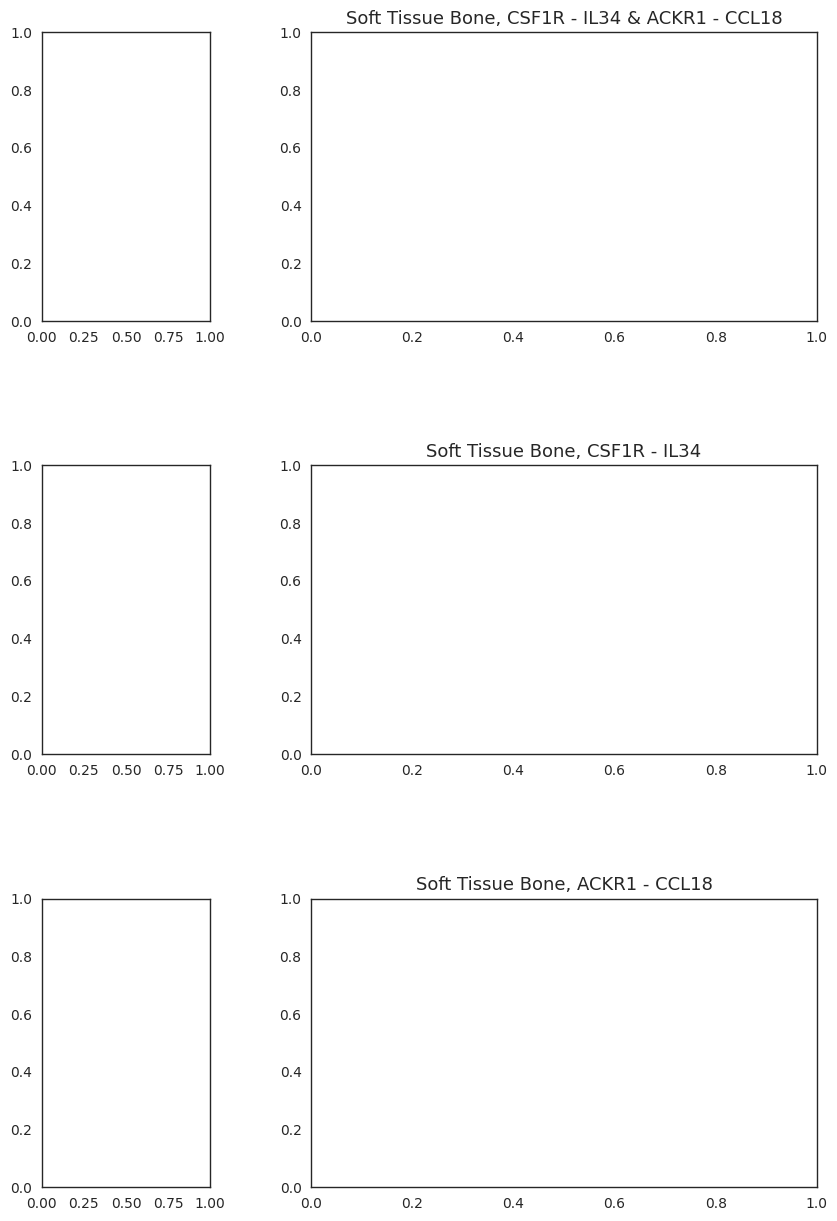

In [19]:
for tissue in to_plot['tissue'].unique():
    print(tissue)
    survival_df = pd.read_csv('/home/lnemati/pathway_crosstalk/data/survival_data/tissues/' + tissue.lower().replace(' ', '_') + '.csv', index_col=0)
    for interactions in to_plot.query('tissue == @tissue')['interaction']:
        print(interactions)
        # Uncropped
        #outdir =  os.path.join('/home/lnemati/pathway_crosstalk/results/survival/plots/', 'uncropped', tissue)
        outdir =  os.path.join('/home/lnemati/pathway_crosstalk/results/figures/survival/survival_curves', 'uncropped', tissue)
        os.makedirs(outdir, exist_ok=True)
        #plot_all_3(interactions, tissue, survival_df, xlim=(0, 15), ylim=(0., 1.01), show=True)#, savepath=os.path.join(outdir, interactions))
        plot_all_3(interactions, tissue, survival_df, xlim=(0, 15), ylim=(0., 1.01), show=False, savepath=os.path.join(outdir, interactions))
 
        ## Cropped
        #outdir =  os.path.join('/home/lnemati/pathway_crosstalk/results/survival/plots/', 'cropped', tissue)
        outdir =  os.path.join('/home/lnemati/pathway_crosstalk/results/figures/survival/survival_curves', 'cropped', tissue)
        os.makedirs(outdir, exist_ok=True)
        plot_all_3(interactions, tissue, survival_df, xlim=(0, 15), ylim=(0.5, 1.005), show=False, savepath=os.path.join(outdir, interactions)+'_crop1')
        plot_all_3(interactions, tissue, survival_df, xlim=(0, 10), ylim=(0.5, 1.005), show=False, savepath=os.path.join(outdir, interactions)+'_crop2')
        plot_all_3(interactions, tissue, survival_df, xlim=(0, 5 ), ylim=(0.5, 1.005), show=False, savepath=os.path.join(outdir, interactions)+'_crop3')

# uncropped 0 15
# crop1 0.5 15
# crop2 0.5 10
# crop3 0.5 5

In [ ]:
def survival(interactions, df):
    import pandas as pd
    from lifelines import KaplanMeierFitter
    import re   
    
    df = df.copy()
    
    # Extract genes from the interaction string
    genes = list(set(re.split(r'[+&_]', interactions)))

    # Check if there are multiple conditions
    multiple_conditions = len(df['condition'].unique()) > 1

    # Filter and process the DataFrame
    cols = ['OS.time', 'OS', 'condition'] + genes
    df = df[cols]

    # Convert columns to numeric, except for condition
    df.loc[:, [col for col in df.columns if col != 'condition']] = (
        df.loc[:, [col for col in df.columns if col != 'condition']].apply(pd.to_numeric, errors='coerce')
    )
    df = df.dropna()

    # Convert OS time to years
    df['OS.time'] = df['OS.time'] / 365

    high_expression_group = pd.DataFrame()
    low_expression_group = pd.DataFrame()

    if multiple_conditions:
        # If there are multiple conditions, split the patients based on each condition
        for condition in df['condition'].unique():
            condition_df = df[df['condition'] == condition]
            
            # Calculate medians for each gene within the condition
            medians = condition_df[genes].median()
            
            # Identify patients above/below the median for all genes
            high_expression = condition_df[(condition_df[genes] > medians).T.all()]
            low_expression = condition_df[(condition_df[genes] <= medians).T.all()]
            
            # Append to the respective groups
            high_expression_group = pd.concat([high_expression_group, high_expression])
            low_expression_group = pd.concat([low_expression_group, low_expression])
    else:
        # If there is only one condition, split based on the entire dataset
        medians = df[genes].median()
        high_expression_group = df[(df[genes] > medians).T.all()]
        low_expression_group = df[(df[genes] <= medians).T.all()]

    # Remove patients that are in both groups
    common_patients = high_expression_group.index.intersection(low_expression_group)
    high_expression_group = high_expression_group[~high_expression_group.index.isin(common_patients)]
    low_expression_group  = low_expression_group[ ~low_expression_group.index.isin( common_patients)]
        
    # Count number of patients
    n_patients_low = low_expression_group.shape[0]
    n_patients_high = high_expression_group.shape[0]

    # Fit the Kaplan-Meier estimators
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()

    kmf_low.fit(
        low_expression_group['OS.time'],
        event_observed=low_expression_group['OS'],
        label="Low Expression"
    )
    kmf_high.fit(
        high_expression_group['OS.time'],
        event_observed=high_expression_group['OS'],
        label="High Expression"
    )

    return {
        'name': interactions,
        'kmf_low': kmf_low,
        'kmf_high': kmf_high,
        'low_expression': low_expression_group.index,
        'high_expression': high_expression_group.index,
    }

In [ ]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts
import matplotlib.patheffects as path_effects  # Import PathEffects for text outlines
from matplotlib.gridspec import GridSpec

def get_genes(string):
    genes = list(re.split(r'[+&_]', string))

    # Remove duplicates while preserving order
    seen = set()
    ordered_genes = []
    for gene in genes:
        if gene not in seen:
            seen.add(gene)
            ordered_genes.append(gene)

    return ordered_genes

def plot_all_3(interaction, tissue, survival_df, xlim=(0, 15), ylim=(0, 1.01), savepath=None, show=True):
    
    df = survival_df.copy()
    # Change index from samples to patients
    df.index = df.index.str.rsplit(pat='-', n=1, expand=True).get_level_values(0) 
        
    #fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    #fig.suptitle(tissue.replace('_', ' ').title().replace(' And ', ' & '), fontsize=12, y=0.92)
    #plt.subplots_adjust(hspace=0.5)
    interaction_results = survival(interaction, df)
    
    fig = plt.figure(figsize=(10, 15))
    gs = GridSpec(3, 2, width_ratios=[1, 3], height_ratios=[1,1,1], figure=fig)

    axes = []
    for row in range(3):
        ax_box = fig.add_subplot(gs[row, 0])   # Boxplot on left, narrower
        ax_km = fig.add_subplot(gs[row, 1])    # Survival curve on right, wider
        axes.append((ax_box, ax_km))

    fig.suptitle(tissue.replace('_', ' ').title().replace(' And ', ' & '), fontsize=12, y=0.92)
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    
    int1, int2 = interaction.split('&')
    interaction_results1 = survival(int1, df)
    interaction_results2 = survival(int2, df)

    fs = 13
    
    # Plot the KM curves for both groups on the same plot
    for ax, result in zip(axes, (interaction_results, interaction_results1, interaction_results2)):
        name = result['name']
        genes = get_genes(name)
        
        pval = rawdf.set_index(['interaction', 'tissue']).loc[(name, tissue), 'logrank_pval']
        n_low = rawdf.set_index(['interaction', 'tissue']).loc[(name, tissue), 'n_patients_low']
        n_high = rawdf.set_index(['interaction', 'tissue']).loc[(name, tissue), 'n_patients_high']
        #pval = result['p_value']
                
        ci = False
        censors=True
        result['kmf_low'].plot_survival_function(
            ax=ax[1],
            color=ncolor,
            ci_show=ci,
            show_censors=censors,
            label='Low Expression, N={}'.format(n_low)
        )
        result['kmf_high'].plot_survival_function(
            ax=ax[1],
            color=tcolor,
            ci_show=ci,
            show_censors=censors,
            label='High Expression, N={}'.format(n_high)

        )
        add_at_risk_counts(result['kmf_low'], result['kmf_high'], ax=ax[1], ypos=-0.35, rows_to_show=['At risk'])
        
        ax[0].set_title(name, fontsize=fs)
        ax[1].set_title(name, fontsize=fs)
        
        ax[1].set_xlabel('Time (Years)', fontsize=fs)
        ax[1].set_ylabel('Survival Prob.', fontsize=fs)
        
        ax[1].set_xlim(xlim[0], xlim[1])
        ax[1].set_ylim(ylim[0], ylim[1])
        
        ax[1].legend(fontsize=fs, framealpha=0.5, loc='upper right')
        
        ypos = ax[1].get_ylim()[0] + 0.06*(ax[1].get_ylim()[1] - ax[1].get_ylim()[0])
        xpos = ax[1].get_xlim()[0] + 0.015*(ax[1].get_xlim()[1] - ax[1].get_xlim()[0])

        text = ax[1].text(xpos, ypos, '$p={:.1e}$'.format(pval), fontsize=0.8*fs)
        text.set_path_effects([
            path_effects.Stroke(linewidth=8, foreground=(1,1,1,0.5)),  # White outline
            path_effects.Normal()  # Normal text
        ])
        
        df['Group'] = None
        df.loc[df.index.isin(result['high_expression']), 'Group'] = 'High Expression'
        df.loc[df.index.isin(result['low_expression']), 'Group'] = 'Low Expression'
        violindata = df.melt(id_vars=['Group'], value_vars=genes)

        # Reorder violindata based on the genes list
        violindata['variable'] = pd.Categorical(violindata['variable'], categories=genes, ordered=True)

        # Create violin plot with explicit order
        #sns.violinplot(
        #    data=violindata,
        #    x='variable',
        #    y='value',
        #    hue='Group',
        #    ax=ax[0],
        #    palette={'High Expression': tcolor, 'Low Expression': ncolor},
        #    order=genes,
        #    inner=None,
        #    cut=0
        #)
        
        sns.boxplot(
            data=violindata,
            x='variable',
            y='value',
            hue='Group',
            ax=ax[0],
            palette={'High Expression': tcolor, 'Low Expression': ncolor},
            order=genes,
            fliersize=0,
            #inner=None,
            #cut=0
        )

        # Define the offset for the median line
        x_offset = 0.4
        lw = 2  # linewidth
        color = 'k'  # line color
        ls = '-'  # line style

        # Compute medians, preserving the order in genes
        median_values = (
            violindata.groupby('variable')['value'].median()
            .reindex(genes)  # Reorder by genes list
            .reset_index()
        )

        # Loop to add median lines with offset and collect coordinates
        #for i, (gene, median) in enumerate(zip(median_values['variable'], median_values['value'])):
        #    # Collect coordinates for the horizontal line (hlines)
        #        ax[0].plot([i - x_offset, i + x_offset], [median, median], color=color, linestyle=ls, linewidth=lw)

        #ax[0].set_xlim(-x_offset, len(genes)-1+x_offset)
        #ax[0].legend([])
        ax[0].set_xlabel('Gene', fontsize=fs)
        ax[0].set_ylabel('log2(0.001 + TPM)', fontsize=fs)
        ax[0].get_legend().remove()
        
        ax[0].tick_params(labelsize=fs)
        ax[1].tick_params(labelsize=fs)
        
        ax[0].spines[['bottom', 'left']].set_color('black')
        ax[0].spines[['right', 'top']].set_visible(False)
        ax[1].spines[['bottom', 'left']].set_color('black')
        ax[1].spines[['right', 'top']].set_visible(False)

    if savepath is not None:
        plt.savefig(savepath+'.pdf', bbox_inches='tight')
        plt.savefig(savepath+'.png', bbox_inches='tight')
    
    if show == True:
        plt.show()
    
    plt.clf()
    return

In [ ]:
#subset = better.query('motif in ["3_clique", "4_clique"] and min_patients >= 50')
#subset = subset.query('logrank_pval1 > 0.01 and logrank_pval2 > 0.01')
#subset = subset.query('hr_lfc_best > 0.58 and concordance_index > 0.5')
#subset = subset.query('not ((hr - se) < 1 and (hr + se) > 1)')
#
#subset.loc[subset['tissue'] == 'Thyroid_Gland', 'tissue'] = 'Thyroid'
#
#subset = subset.sort_values(by='c_diff_best', ascending=False)
#subset['c_rank'] = range(subset.shape[0])
#subset = subset.sort_values(by='hr_lfc_best', ascending=False)
#subset['hr_rank'] = range(subset.shape[0])
#subset['rank'] = subset['c_rank'] + subset['hr_rank']
#subset = subset.sort_values(by='rank')
#
#subset['sign'] = subset['log2_hr'] > 0
#to_plot =  subset.groupby(['tissue', 'sign']).head(3)
#to_plot = to_plot.sort_values(by='tissue')

In [ ]:
to_plot = better.loc[barplot_indexes]

In [ ]:
for tissue in to_plot['tissue'].unique():
    print(tissue)
    survival_df = pd.read_csv('/home/lnemati/pathway_crosstalk/data/survival_data/tissues/' + tissue.lower().replace(' ', '_') + '.csv', index_col=0)
    for interactions in to_plot.query('tissue == @tissue')['interaction']:
        print(interactions)
        # Uncropped
        outdir =  os.path.join('/home/lnemati/pathway_crosstalk/results/survival/plots/', 'uncropped', tissue)
        os.makedirs(outdir, exist_ok=True)
        #plot_all_3(interactions, tissue, survival_df, xlim=(0, 15), ylim=(0., 1.01), show=False, savepath=os.path.join(outdir, interactions))
        plot_all_3(interactions, tissue, survival_df, xlim=(0, 15), ylim=(0., 1.01), show=True)#, savepath=os.path.join(outdir, interactions))
 
        ## Cropped
        #outdir =  os.path.join('/home/lnemati/pathway_crosstalk/results/survival/plots/', 'cropped', tissue)
        #os.makedirs(outdir, exist_ok=True)
        #plot_all_3(interactions, tissue, survival_df, xlim=(0, 15), ylim=(0.5, 1.005), show=False, savepath=os.path.join(outdir, interactions)+'_crop1')
        #plot_all_3(interactions, tissue, survival_df, xlim=(0, 10), ylim=(0.5, 1.005), show=False, savepath=os.path.join(outdir, interactions)+'_crop2')
        #plot_all_3(interactions, tissue, survival_df, xlim=(0, 5 ), ylim=(0.5, 1.005), show=False, savepath=os.path.join(outdir, interactions)+'_crop3')

        print('------------------------------------------')
        print()
        print()
        print()
        print()
        print()
        print()

# uncropped 0 15
# crop1 0.5 15
# crop2 0.5 10
# crop3 0.5 5

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from PIL import Image
import os
from scipy.stats import pearsonr, spearmanr
import numpy as np

titlefs = 14
fs = 11
smallfs = 9
height = 0.8
N = 15  # number of hallmarks to select

# Example: Replace with your actual data
# barplotdf, heatmap_df should be defined before this point

# Preprocessing
hallmark_counts = (heatmap_df != 0).sum(axis=0)
top_hallmarks = hallmark_counts.sort_values(ascending=False).head(N).index
top_heatmap_df = heatmap_df[top_hallmarks]

barplotdf = barplotdf.sort_values(by='log2_hr', ascending=True)
y_pos = np.arange(len(barplotdf))
top_heatmap_df = top_heatmap_df.loc[barplotdf['interaction']]
hallmark_matrix = top_heatmap_df.values

# Create mosaic layout
fig, axs = plt.subplot_mosaic(
    """
    KKKKAA
    XXYYBB
    XXYYCC
    """,
    dpi=300,
    figsize=(15, 15),
)

############# AXIS K: Correlation ##############

ax = axs['K']

# --- Constants ---
dpi = 300
img_dir = '/home/lnemati/pathway_crosstalk/data/motifs_icons/'
image_scaling_factor = 0.55  # smaller for subplot usage

x_offset = -1
y_offset = 0.0025

# --- Filter Data ---
df = better.query('tissue != "Pan_Cancer"')
all_counts = crosstalkdf.query('tissue != "Pan_Cancer"').motif.value_counts().sort_values(ascending=False)
probs = (df.motif.value_counts() / all_counts).sort_values()
probs = probs.loc[motifs_z.index]

data = pd.DataFrame({'z': motifs_z, 'prob': probs})

# --- Correlation ---
r_value, p_r_value = pearsonr(probs, motifs_z)
rho_value, p_rho_value = spearmanr(probs, motifs_z)

# --- Plot ---

# Scatter
ax.scatter(data['z'], data['prob'], color='black', marker='x', s=70, linewidths=1.5)

# Correlation text
ax.text(0.95, 0.05, f'r={r_value:.2f}\np={p_r_value:.3f}',
        transform=ax.transAxes, fontsize=fs, ha='right')

# Axes settings
ax.set_xlim(-8, 8)
ax.set_ylim(0.022, 0.038)
ax.set_xticks([-8, -4, 0, 4, 8])
ax.set_yticks([0.025, 0.030, 0.035])
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=fs)
ax.set_title('Probability of Motifs Stratifying Patients\nBetter than Individual Interactions', fontsize=fs)
ax.set_xlabel('Motif Enrichment (Z-Score)', fontsize=fs)
ax.set_ylabel('Probability', fontsize=fs)

# Regression line
slope, intercept = np.polyfit(data['z'], data['prob'], 1)
x_extended = np.linspace(ax.get_xlim()[0] + 0.5, ax.get_xlim()[1] - 0.5, 100)
y_extended = slope * x_extended + intercept
ax.plot(x_extended, y_extended, linestyle='--', color='k', linewidth=1.5, zorder=-10)

motif_positions = {
    '3_path': (data['z']['3_path'], data['prob']['3_path']),
    '4_cycle': (data['z']['4_cycle'] - 0.45, data['prob']['4_cycle'] - 0.0005),
    '4_triangle_extra': (data['z']['4_triangle_extra']-0.5, data['prob']['4_triangle_extra'] - 0.005),
    '4_one_missing': (data['z']['4_one_missing'] + 2.25, data['prob']['4_one_missing'] - 0.005),
    '4_path': (data['z']['4_path'], data['prob']['4_path']),
    '4_no_crosstalk': (data['z']['4_no_crosstalk'] + 2.5, data['prob']['4_no_crosstalk'] - 0.005),
    '3_clique': (data['z']['3_clique'] - 0.4, data['prob']['3_clique'] - 0.001),
    '4_clique': (data['z']['4_clique'] + 2.3, data['prob']['4_clique'] - 0.005),
}

#motif_positions = {k: (data['z'][k], data['prob'][k]) for k in data.index}

# --- Add motif icons using inset_axes ---
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

for motif, (x_pos, y_pos) in motif_positions.items():
    img_path = os.path.join(img_dir, f"{motif}.png")
    x_pos += x_offset
    y_pos += y_offset
    if os.path.exists(img_path):
        # Convert data coordinates to axis-relative
        inv = ax.transData.transform
        trans = ax.transAxes.inverted().transform
        ax_rel_coords = trans(inv((x_pos, y_pos)))

        # Create inset axes at that location
        ax_img = inset_axes(ax,
                            width=image_scaling_factor,
                            height=image_scaling_factor,
                            loc='center',
                            bbox_to_anchor=(ax_rel_coords[0], ax_rel_coords[1]),
                            bbox_transform=ax.transAxes,
                            borderpad=0)

        # Load and show image
        im = Image.open(img_path)
        ax_img.imshow(im)
        ax_img.axis('off')

        # Line from data point to image center
        x0, y0 = data['z'][motif], data['prob'][motif]  # data point
        x1, y1 = x_pos, y_pos  # image anchor
        dx, dy = x1 - x0, y1 - y0
        length = np.hypot(dx, dy)
        line_frac = 0.5
        marker_trim = 0.25
        dxn, dyn = dx / length, dy / length
        x_start, y_start = x0 + dxn * marker_trim, y0 + dyn * marker_trim
        x_end, y_end = x1 - dxn * (line_frac * length), y1 - dyn * (line_frac * length)
        ax.plot([x_start, x_end], [y_start, y_end], color='k', linewidth=0.5, zorder=-5)

# Legend (optional, usually omitted for clarity)
# ax.legend(fontsize=fs, loc='upper left')

############# AXIS B: Barplot ####################
ax = axs['X']

# Count how many interactions have each hallmark (non-zero values)
hallmark_counts = (heatmap_df != 0).sum(axis=0)

# Select top N hallmarks by count
top_hallmarks = hallmark_counts.sort_values(ascending=False).head(N).index
top_heatmap_df = heatmap_df[top_hallmarks]

# Sort barplotdf by log2_hr ascending and get y positions
barplotdf = barplotdf.sort_values(by='log2_hr', ascending=True)
y_pos = np.arange(len(barplotdf))

# Use your top_heatmap_df from earlier (rows = interactions, cols = top hallmarks)
# Make sure it aligns with barplotdf index order
top_heatmap_df = top_heatmap_df.loc[barplotdf['interaction']]

# Prepare the matrix for imshow
hallmark_matrix = top_heatmap_df.values

for j, (i, row) in enumerate(barplotdf.iterrows()):
    ypos = y_pos[j]
    hr1 = row['log2_hr1']
    hr2 = row['log2_hr2']
    hr = row['log2_hr']

    if hr1 != 0:
        ax.barh(ypos, hr1, color='C0', height=height, edgecolor='k', linewidth=1)

    if hr1 * hr2 < 0:
        left2 = 0
        width2 = hr2
    else:
        left2 = hr1
        width2 = hr2 - hr1
    ax.barh(ypos, width2, left=left2, color='C1', height=height, edgecolor='k', linewidth=1)

    width3 = hr - hr2
    color = tcolor if hr > 0 else ncolor
    if width3 != 0:
        ax.barh(ypos, width3, left=hr2, color=color, height=height, edgecolor='k', linewidth=1)

# Tissue labels
for j, row in enumerate(barplotdf.itertuples()):
    ypos = y_pos[j]
    tissue = row.tissue
    hr = row.log2_hr
    if hr >= 0:
        ax.text(-0.25, ypos, tissue, va='center', ha='right', fontsize=smallfs)
    else:
        ax.text(0.25, ypos, tissue, va='center', ha='left', fontsize=smallfs)

ax.set_yticks(y_pos)
ax.set_yticklabels(barplotdf['interaction'], fontsize=smallfs)
ax.invert_yaxis()
ax.set_xlabel('log$_2$(Hazard Ratio)', fontsize=fs)
ax.set_ylabel('Interaction', fontsize=fs)
ax.set_ylim(-1, len(barplotdf))
ax.tick_params(axis='x', labelsize=smallfs)
ax.set_xlim(-7.5, 7.5)

N_neg = sum(barplotdf['log2_hr'] < 0)
ax.axhline(N_neg - 0.5, color='black', linewidth=2, linestyle='-')

# Color y-axis labels
y_labels = ax.get_yticklabels()
for i, label in enumerate(y_labels):
    label.set_color(ncolor if i < N_neg else tcolor)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Hazard Ratios of Cliques and Individual CCIs', fontsize=titlefs)
ax.tick_params(bottom=True, top=False, left=True, labelbottom=True, length=6, width=1.2)

############# AXIS C: Heatmap ####################
ax_hm = axs['Y']

# Remove spines
for spine in ax_hm.spines.values():
    spine.set_visible(False)

ax_hm.clear()
ax_hm.set_yticks([])
ax_hm.tick_params(axis='x', which='both', bottom=True, top=False, length=6, width=1.2)
ax_hm.tick_params(axis='y', which='both', bottom=True, top=False, length=6, width=1.2)

ax_hm.set_xticks(np.arange(len(top_heatmap_df.columns)) + 0.5)
ax_hm.set_xticklabels(top_heatmap_df.columns, rotation=90, fontsize=smallfs)
ax_hm.set_xticks(np.arange(len(top_heatmap_df.columns)+1), minor=True)
ax_hm.set_yticks(np.arange(hallmark_matrix.shape[0]+1)-0.5, minor=True)
ax_hm.grid(which='minor', color='white', linewidth=2.5)
ax_hm.tick_params(which='minor', bottom=False, left=False, length=6, width=1.2)

# Draw the matrix
cell_height = 1
cell_width = 1
for row_idx in range(hallmark_matrix.shape[0]):
    for col_idx in range(hallmark_matrix.shape[1]):
        val = hallmark_matrix[row_idx, col_idx]
        y = row_idx
        x = col_idx

        if val == 0:
            rect = patches.Rectangle((x, y), cell_width, cell_height, facecolor='white', edgecolor='lightgray', linewidth=0.5)
            ax_hm.add_patch(rect)
        elif val == 1:
            rect = patches.Rectangle((x, y), cell_width, cell_height, facecolor='C0', edgecolor='k', linewidth=0.5)
            ax_hm.add_patch(rect)
        elif val == 2:
            rect = patches.Rectangle((x, y), cell_width, cell_height, facecolor='C1', edgecolor='k', linewidth=0.5)
            ax_hm.add_patch(rect)
        elif val == 3:
            xy = [(x, y), (x + cell_width, y), (x + cell_width, y + cell_height), (x, y + cell_height)]
            tri1 = patches.Polygon([xy[0], xy[3], xy[2]], facecolor='C0', edgecolor='k', linewidth=0.5)
            tri2 = patches.Polygon([xy[0], xy[1], xy[2]], facecolor='C1', edgecolor='k', linewidth=0.5)
            ax_hm.add_patch(tri1)
            ax_hm.add_patch(tri2)

ax_hm.set_xlim(0, hallmark_matrix.shape[1])
ax_hm.set_ylim(-0.5, hallmark_matrix.shape[0]+0.5)
ax_hm.set_aspect('equal', adjustable='datalim')
ax_hm.axhline(N_neg, color='black', linewidth=2, linestyle='-')
ax_hm.set_title('Biological Processes', fontsize=titlefs)

############# Labels and Legends ##############

props = dict(boxstyle='round,pad=0.5', facecolor='none', edgecolor='black', linewidth=1)
ax.text(0.8, 0.48, ' High Expression \nLow Survival\n\n\n\n\n\n', ha='center', va='center', fontsize=smallfs, transform=ax.transAxes, bbox=props)
ax.text(0.2, 0.35, ' Low Expression \nLow Survival\n\n\n\n\n\n', ha='center', va='center', fontsize=smallfs, transform=ax.transAxes, bbox=props)

# Legend (High expression)
legend_x, legend_y = 0.64, 0.475
width, height = 0.08, 0.013
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor='C0', edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'First CCI', transform=ax.transAxes,
        va='center', fontsize=smallfs)
legend_y -= 0.02
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor='C1', edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'Second CCI', transform=ax.transAxes,
        va='center', fontsize=smallfs)
legend_y -= 0.02
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor=tcolor, edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'Full Clique', transform=ax.transAxes,
        va='center', fontsize=smallfs)

# Legend (Low expression)
legend_x, legend_y = 0.045, 0.345
width, height = 0.08, 0.015
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor='C0', edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'First CCI', transform=ax.transAxes,
        va='center', fontsize=smallfs)
legend_y -= 0.02
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor='C1', edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'Second CCI', transform=ax.transAxes,
        va='center', fontsize=smallfs)
legend_y -= 0.02
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor=ncolor, edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'Full Clique', transform=ax.transAxes,
        va='center', fontsize=smallfs)

plt.show()


# Survival Curves

In [ ]:
rawdf = pd.read_csv('/home/lnemati/pathway_crosstalk/results/survival/aggregate/all_unfiltered.csv')
crosstalkdf = pd.read_csv('/home/lnemati/pathway_crosstalk/results/survival/aggregate/all_pairs.csv')

significant = crosstalkdf.query('pval_adj < 0.05')
significant = significant.query('not ((hr - se) < 1 and 1 < (hr + se))')

better = significant.copy()
better = better.query('hr_lfc_best > 0.')
better = better.query('c_diff_best > 0.')
better = better.query('(logrank_pval < logrank_pval1) and (logrank_pval < logrank_pval2)')

better.head(3)

In [ ]:
def survival(interactions, df):
    import pandas as pd
    from lifelines import KaplanMeierFitter
    import re   
    
    df = df.copy()
    
    # Extract genes from the interaction string
    genes = list(set(re.split(r'[+&_]', interactions)))

    # Check if there are multiple conditions
    multiple_conditions = len(df['condition'].unique()) > 1

    # Filter and process the DataFrame
    cols = ['OS.time', 'OS', 'condition'] + genes
    df = df[cols]

    # Convert columns to numeric, except for condition
    df.loc[:, [col for col in df.columns if col != 'condition']] = (
        df.loc[:, [col for col in df.columns if col != 'condition']].apply(pd.to_numeric, errors='coerce')
    )
    df = df.dropna()

    # Convert OS time to years
    df['OS.time'] = df['OS.time'] / 365

    high_expression_group = pd.DataFrame()
    low_expression_group = pd.DataFrame()

    if multiple_conditions:
        # If there are multiple conditions, split the patients based on each condition
        for condition in df['condition'].unique():
            condition_df = df[df['condition'] == condition]
            
            # Calculate medians for each gene within the condition
            medians = condition_df[genes].median()
            
            # Identify patients above/below the median for all genes
            high_expression = condition_df[(condition_df[genes] > medians).T.all()]
            low_expression = condition_df[(condition_df[genes] <= medians).T.all()]
            
            # Append to the respective groups
            high_expression_group = pd.concat([high_expression_group, high_expression])
            low_expression_group = pd.concat([low_expression_group, low_expression])
    else:
        # If there is only one condition, split based on the entire dataset
        medians = df[genes].median()
        high_expression_group = df[(df[genes] > medians).T.all()]
        low_expression_group = df[(df[genes] <= medians).T.all()]

    # Remove patients that are in both groups
    common_patients = high_expression_group.index.intersection(low_expression_group)
    high_expression_group = high_expression_group[~high_expression_group.index.isin(common_patients)]
    low_expression_group  = low_expression_group[ ~low_expression_group.index.isin( common_patients)]
        
    # Count number of patients
    n_patients_low = low_expression_group.shape[0]
    n_patients_high = high_expression_group.shape[0]

    # Fit the Kaplan-Meier estimators
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()

    kmf_low.fit(
        low_expression_group['OS.time'],
        event_observed=low_expression_group['OS'],
        label="Low Expression"
    )
    kmf_high.fit(
        high_expression_group['OS.time'],
        event_observed=high_expression_group['OS'],
        label="High Expression"
    )

    return {
        'name': interactions,
        'kmf_low': kmf_low,
        'kmf_high': kmf_high,
        'low_expression': low_expression_group.index,
        'high_expression': high_expression_group.index,
    }

In [ ]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts
import matplotlib.patheffects as path_effects  # Import PathEffects for text outlines
from matplotlib.gridspec import GridSpec

def get_genes(string):
    genes = list(re.split(r'[+&_]', string))

    # Remove duplicates while preserving order
    seen = set()
    ordered_genes = []
    for gene in genes:
        if gene not in seen:
            seen.add(gene)
            ordered_genes.append(gene)

    return ordered_genes

def plot_all_3(interaction, tissue, survival_df, xlim=(0, 15), ylim=(0, 1.01), savepath=None, show=True):
    
    df = survival_df.copy()
    # Change index from samples to patients
    df.index = df.index.str.rsplit(pat='-', n=1, expand=True).get_level_values(0) 
        
    #fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    #fig.suptitle(tissue.replace('_', ' ').title().replace(' And ', ' & '), fontsize=12, y=0.92)
    #plt.subplots_adjust(hspace=0.5)
    interaction_results = survival(interaction, df)
    
    fig = plt.figure(figsize=(12, 12))
    gs = GridSpec(3, 2, width_ratios=[1, 2], height_ratios=[1,1,1], figure=fig)

    axes = []
    for row in range(3):
        ax_box = fig.add_subplot(gs[row, 0])   # Boxplot on left, narrower
        ax_km = fig.add_subplot(gs[row, 1])    # Survival curve on right, wider
        axes.append((ax_box, ax_km))

    fig.suptitle(tissue.replace('_', ' ').title().replace(' And ', ' & '), fontsize=12, y=0.92)
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    
    int1, int2 = interaction.split('&')
    interaction_results1 = survival(int1, df)
    interaction_results2 = survival(int2, df)

    fs = 13
    
    # Plot the KM curves for both groups on the same plot
    for ax, result in zip(axes, (interaction_results, interaction_results1, interaction_results2)):
        name = result['name']
        genes = get_genes(name)
        
        pval = rawdf.set_index(['interaction', 'tissue']).loc[(name, tissue), 'logrank_pval']
        n_low = rawdf.set_index(['interaction', 'tissue']).loc[(name, tissue), 'n_patients_low']
        n_high = rawdf.set_index(['interaction', 'tissue']).loc[(name, tissue), 'n_patients_high']
        #pval = result['p_value']
                
        ci = False
        censors=True
        result['kmf_low'].plot_survival_function(
            ax=ax[1],
            color=ncolor,
            ci_show=ci,
            show_censors=censors,
            label='Low Expression, N={}'.format(n_low)
        )
        result['kmf_high'].plot_survival_function(
            ax=ax[1],
            color=tcolor,
            ci_show=ci,
            show_censors=censors,
            label='High Expression, N={}'.format(n_high)

        )
        add_at_risk_counts(result['kmf_low'], result['kmf_high'], ax=ax[1], ypos=-0.35, rows_to_show=['At risk'])
        
        ax[0].set_title(name, fontsize=fs)
        ax[1].set_title(name, fontsize=fs)
        
        ax[1].set_xlabel('Time (Years)', fontsize=fs)
        ax[1].set_ylabel('Survival Prob.', fontsize=fs)
        
        ax[1].set_xlim(xlim[0], xlim[1])
        ax[1].set_ylim(ylim[0], ylim[1])
        
        ax[1].legend(fontsize=fs, framealpha=0.5, loc='upper right')
        
        ypos = ax[1].get_ylim()[0] + 0.06*(ax[1].get_ylim()[1] - ax[1].get_ylim()[0])
        xpos = ax[1].get_xlim()[0] + 0.015*(ax[1].get_xlim()[1] - ax[1].get_xlim()[0])

        text = ax[1].text(xpos, ypos, '$p={:.1e}$'.format(pval), fontsize=0.8*fs)
        text.set_path_effects([
            path_effects.Stroke(linewidth=8, foreground=(1,1,1,0.5)),  # White outline
            path_effects.Normal()  # Normal text
        ])
        
        df['Group'] = None
        df.loc[df.index.isin(result['high_expression']), 'Group'] = 'High Expression'
        df.loc[df.index.isin(result['low_expression']), 'Group'] = 'Low Expression'
        violindata = df.melt(id_vars=['Group'], value_vars=genes)

        # Reorder violindata based on the genes list
        violindata['variable'] = pd.Categorical(violindata['variable'], categories=genes, ordered=True)

        # Create violin plot with explicit order
        #sns.violinplot(
        #    data=violindata,
        #    x='variable',
        #    y='value',
        #    hue='Group',
        #    ax=ax[0],
        #    palette={'High Expression': tcolor, 'Low Expression': ncolor},
        #    order=genes,
        #    inner=None,
        #    cut=0
        #)
        
        sns.boxplot(
            data=violindata,
            x='variable',
            y='value',
            hue='Group',
            ax=ax[0],
            palette={'High Expression': tcolor, 'Low Expression': ncolor},
            order=genes,
            fliersize=0,
            #inner=None,
            #cut=0
        )

        # Define the offset for the median line
        x_offset = 0.4
        lw = 2  # linewidth
        color = 'k'  # line color
        ls = '-'  # line style

        # Compute medians, preserving the order in genes
        median_values = (
            violindata.groupby('variable')['value'].median()
            .reindex(genes)  # Reorder by genes list
            .reset_index()
        )

        # Loop to add median lines with offset and collect coordinates
        #for i, (gene, median) in enumerate(zip(median_values['variable'], median_values['value'])):
        #    # Collect coordinates for the horizontal line (hlines)
        #        ax[0].plot([i - x_offset, i + x_offset], [median, median], color=color, linestyle=ls, linewidth=lw)

        #ax[0].set_xlim(-x_offset, len(genes)-1+x_offset)
        #ax[0].legend([])
        ax[0].set_xlabel('Gene', fontsize=fs)
        ax[0].set_ylabel('log2(0.001 + TPM)', fontsize=fs)
        ax[0].get_legend().remove()
        
        ax[0].tick_params(labelsize=fs)
        ax[1].tick_params(labelsize=fs)
        
        ax[0].spines[['bottom', 'left']].set_color('black')
        ax[0].spines[['right', 'top']].set_visible(False)
        ax[1].spines[['bottom', 'left']].set_color('black')
        ax[1].spines[['right', 'top']].set_visible(False)

    if savepath is not None:
        plt.savefig(savepath+'.pdf', bbox_inches='tight')
        plt.savefig(savepath+'.png', bbox_inches='tight')
    
    if show == True:
        plt.show()
    
    plt.clf()
    return
    
#interaction = 'CD4+IL16&BDNF+NGFR'
#urvival_df = pd.read_csv('/home/lnemati/pathway_crosstalk/data/survival_data/kidney.csv', index_col=0)
#plot_all_3('COL6A3+ITGA2_ITGB1&PLXNA1+SEMA5B', survival_df)

In [ ]:
#subset = better.query('motif in ["3_clique", "4_clique"] and min_patients >= 50')
#subset = subset.query('logrank_pval1 > 0.01 and logrank_pval2 > 0.01')
#subset = subset.query('hr_lfc_best > 0.58 and concordance_index > 0.5')
#subset = subset.query('not ((hr - se) < 1 and (hr + se) > 1)')
#
#subset.loc[subset['tissue'] == 'Thyroid_Gland', 'tissue'] = 'Thyroid'
#
#subset = subset.sort_values(by='c_diff_best', ascending=False)
#subset['c_rank'] = range(subset.shape[0])
#subset = subset.sort_values(by='hr_lfc_best', ascending=False)
#subset['hr_rank'] = range(subset.shape[0])
#subset['rank'] = subset['c_rank'] + subset['hr_rank']
#subset = subset.sort_values(by='rank')
#
#subset['sign'] = subset['log2_hr'] > 0
#to_plot =  subset.groupby(['tissue', 'sign']).head(3)
#to_plot = to_plot.sort_values(by='tissue')

In [ ]:
to_plot = better.loc[barplot_indexes]

In [ ]:
for tissue in to_plot['tissue'].unique():
    print(tissue)
    survival_df = pd.read_csv('/home/lnemati/pathway_crosstalk/data/survival_data/tissues/' + tissue.lower().replace(' ', '_') + '.csv', index_col=0)
    for interactions in to_plot.query('tissue == @tissue')['interaction']:
        print(interactions)
        # Uncropped
        outdir =  os.path.join('/home/lnemati/pathway_crosstalk/results/survival/plots/', 'uncropped', tissue)
        os.makedirs(outdir, exist_ok=True)
        #plot_all_3(interactions, tissue, survival_df, xlim=(0, 15), ylim=(0., 1.01), show=False, savepath=os.path.join(outdir, interactions))
        plot_all_3(interactions, tissue, survival_df, xlim=(0, 15), ylim=(0., 1.01), show=True)#, savepath=os.path.join(outdir, interactions))
 
        ## Cropped
        #outdir =  os.path.join('/home/lnemati/pathway_crosstalk/results/survival/plots/', 'cropped', tissue)
        #os.makedirs(outdir, exist_ok=True)
        #plot_all_3(interactions, tissue, survival_df, xlim=(0, 15), ylim=(0.5, 1.005), show=False, savepath=os.path.join(outdir, interactions)+'_crop1')
        #plot_all_3(interactions, tissue, survival_df, xlim=(0, 10), ylim=(0.5, 1.005), show=False, savepath=os.path.join(outdir, interactions)+'_crop2')
        #plot_all_3(interactions, tissue, survival_df, xlim=(0, 5 ), ylim=(0.5, 1.005), show=False, savepath=os.path.join(outdir, interactions)+'_crop3')

    print()
    print()
    print()
    
# uncropped 0 15
# crop1 0.5 15
# crop2 0.5 10
# crop3 0.5 5

In [ ]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import image as mpimg
import os
from PIL import Image

# Constants
dpi = 300
img_dir = '/home/lnemati/pathway_crosstalk/data/motifs_icons/'  # Update this path
image_scaling_factor = 0.3  # Adjust this factor to scale image size (smaller = more zoomed out)
x_offset = -25
y_offset = 100

fs = 16

# Filter data
df = better.query('tissue != "Pan_Cancer"')
all_counts = crosstalkdf.query('tissue != "Pan_Cancer"').motif.value_counts().sort_values(ascending=False)

# Calculate probabilities
probs = (df.motif.value_counts() / all_counts).sort_values()
probs = probs.loc[motifs_z.index]

data = pd.DataFrame()
data['z'] = motifs_z
data['prob'] = probs

# Calculate Pearson correlation
r_value, p_r_value = pearsonr(probs, motifs_z)
rho_value, p_rho_value = spearmanr(probs, motifs_z)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=dpi)

# Plot the scatter points
#ax.scatter(
#    data['z'], 
#    data['prob'], 
#    color=lightgray, 
#    marker='s', 
#    edgecolors='black',  # Black edge color
#    s=70,
#    linewidths=1.5  # Thickness of the edge
#)
ax.scatter(
    data['z'], 
    data['prob'], 
    #color='black', 
    color='black', 
    marker='x', 
    edgecolors='black',  # Black edge color
    s=70,
    linewidths=1.5  # Thickness of the edge
)

# Add Pearson correlation to plot
ax.text(3.5, 0.023, 'r={:.2f}\np={:.3f}'.format(r_value, p_r_value), fontsize=fs)
#ax.text(7, 0.0225, fr"Spearman's $\rho$ = {rho_value:.2f}" + '\n' + f'p-value = {p_rho_value:.2f}', fontsize=fs, ha='right')

# Set limits and ticks
ax.set_xlim(-8, 8)
ax.set_ylim(0.022, 0.038)
xticks = [-8, -4, 0, 4, 8]
yticks = [0.025, 0.030, 0.035]
ax.set_xticks(xticks)
ax.set_yticks(yticks)

# Hide top and right spines
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=fs)

# Add title and labels
ax.set_title('Probability of Motifs Stratifying Patients\nBetter than Individual Interactions', fontsize=fs)
ax.set_xlabel('Motif Enrichment (Z-Score)', fontsize=fs)
ax.set_ylabel('Probability', fontsize=fs)

# Make the background of the plot transparent so the images can show up
ax.patch.set_alpha(0)

# Get the regression line parameters (slope and intercept)
slope, intercept = np.polyfit(data['z'], data['prob'], 1)

# Extend the regression line beyond the data range
x_extended = np.linspace(ax.get_xlim()[0] + 0.5, ax.get_xlim()[1] - 0.5, 100)
y_extended = slope * x_extended + intercept
ax.plot(x_extended, y_extended, linestyle='--', color='k', linewidth=1.5, label='Regression Line', zorder=-10)

# Dictionary to define manual positions for each motif
motif_positions = {
    '3_path': (data['z']['3_path'], data['prob']['3_path']),
    '4_cycle': (data['z']['4_cycle']-0.45, data['prob']['4_cycle']-0.0005),
    '4_triangle_extra': (data['z']['4_triangle_extra'], data['prob']['4_triangle_extra']-0.0022),
    '4_one_missing': (data['z']['4_one_missing']+2.85, data['prob']['4_one_missing']-0.0022),
    '4_path': (data['z']['4_path']+0.25, data['prob']['4_path']),
    '4_no_crosstalk': (data['z']['4_no_crosstalk'], data['prob']['4_no_crosstalk']),
    '3_clique': (data['z']['3_clique'], data['prob']['3_clique']),
    '4_clique': (data['z']['4_clique'], data['prob']['4_clique']-0.0022),
}

# Loop through each motif and place an image at the manually defined position
for motif, (x_pos, y_pos) in motif_positions.items():
    img_path = os.path.join(img_dir, f"{motif}.png")
    if os.path.exists(img_path):
        # Read image
        im = Image.open(img_path)
        
        # Resize the image (scale it down by the factor)
        width, height = im.size
        im_resized = im.resize((int(width * image_scaling_factor), int(height * image_scaling_factor)))

        # Convert resized image to numpy array for figimage
        im_resized = np.array(im_resized)

        # Transform plot coordinates to pixel coordinates
        pixel_pos = ax.transData.transform((x_pos, y_pos))
        
        # Place image at position (centered over the point) with scaled size
        fig.figimage(
            im_resized,
            pixel_pos[0] - im_resized.shape[1] / 2 + x_offset,
            pixel_pos[1] - im_resized.shape[0] / 2 + y_offset, 
            origin="upper"
        )
        
        ## Compute image center in pixel space
        #img_center_x_pix = pixel_pos[0] - im_resized.shape[1] / 2 + x_offset
        #img_center_y_pix = pixel_pos[1] + y_offset
#
        ## Convert image center from pixel to data coordinates
        #img_center_data = ax.transData.inverted().transform((img_center_x_pix, img_center_y_pix))
#
        ## Draw a line from the motif point to the image center
        #ax.plot([motifs_z.loc[motif], img_center_data[0]], [probs.loc[motif], img_center_data[1]], color='gray', linewidth=1, zorder=-5)


# Hide legend, as it may conflict with the images
#plt.legend([], [], frameon=False)
plt.legend(fontsize=fs, loc='upper left')

#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/survival/motifs_z_prob.pdf', bbox_inches='tight', dpi=dpi)
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/survival/motifs_z_prob.png', bbox_inches='tight', dpi=dpi)

# Show the plot
plt.show()


# Barplot by hazard-ratio

In [ ]:
better['log2_hr_abs'] = np.abs(better['log2_hr'])
barplotdf = better.query('motif in ["3_clique", "4_clique"]').sort_values(by='log2_hr_abs')[::-1].groupby('tissue')[['interaction', 'tissue', 'log2_hr', 'log2_hr1', 'log2_hr2']].head(3)
barplot_indexes = barplotdf.index
barplotdf = barplotdf.query('tissue != "Pan_Cancer"')
barplotdf['tissue'] = barplotdf.tissue.str.replace('_', ' ').str.replace(' And ', ' & ')

In [ ]:
for idx, row in barplotdf.iterrows():
    # First interaction must be the closest to zero
    if np.abs(row['log2_hr1']) > np.abs(row['log2_hr2']):
        # reorder values
        val1, val2 = (row['log2_hr1'], row['log2_hr2'])
        barplotdf.at[idx, 'log2_hr1'] = val2
        barplotdf.at[idx, 'log2_hr2'] = val1
        # reorder name
        int1, int2 = row['interaction'].split('&')
        barplotdf.at[idx, 'interaction'] = int2 + '&' + int1

In [ ]:
barplotdf['interaction'] = barplotdf.interaction.str.replace('_', ' - ').str.replace('+', ' - ').str.replace('&', ' & ')

In [ ]:
fs = 14
smallfs = 11

fig, ax = plt.subplots(1, 1, figsize=(5, 15))

# Sort and prepare data
barplotdf = barplotdf.sort_values(by='log2_hr', ascending=True)
y_pos = np.arange(len(barplotdf))

height = 0.8

# Plotting the bar segments
for j, (i, row) in enumerate(barplotdf.iterrows()):
    ypos = y_pos[j]
    
    hr1 = row['log2_hr1']
    hr2 = row['log2_hr2']
    hr = row['log2_hr']
    
    # First segment
    if hr1 != 0:
        ax.barh(ypos, hr1, color='C0', height=height, edgecolor='k', linewidth=1)
    
    # Second segment
    if hr1 * hr2 < 0:
        left2 = 0
        width2 = hr2
    else:
        left2 = hr1
        width2 = hr2 - hr1
    ax.barh(ypos, width2, left=left2, color='C1', height=height, edgecolor='k', linewidth=1)
    
    # Third segment
    width3 = hr - hr2
    color = tcolor if hr > 0 else ncolor
    if width3 != 0:
        ax.barh(ypos, width3, left=hr2, color=color, height=height, edgecolor='k', linewidth=1)

# Add tissue text labels beside the bars
for j, row in enumerate(barplotdf.itertuples()):
    ypos = y_pos[j]
    tissue = row.tissue
    hr = row.log2_hr
    
    if hr >= 0:
        ax.text(-0.25, ypos, tissue, va='center', ha='right', fontsize=smallfs)
    else:
        ax.text(0.25, ypos, tissue, va='center', ha='left', fontsize=smallfs)

# Left Y-axis
ax.set_yticks(y_pos)
ax.set_yticklabels(barplotdf['interaction'], fontsize=fs)
ax.invert_yaxis()
ax.set_xlabel('log$_2$(Hazard Ratio)', fontsize=fs)
ax.set_ylabel('Interaction', fontsize=fs)
ax.set_ylim(-1, len(barplotdf))
ax.tick_params(axis='x', labelsize=fs)
ax.set_xlim(-7.5, 7.5)

# Horizontal line to separate negative/positive
N_neg = sum(barplotdf['log2_hr'] < 0)
ax.axhline(N_neg - 0.5, color='black', linewidth=2, linestyle='-')

# Color y-axis labels
y_labels = ax.get_yticklabels()
for i, label in enumerate(y_labels):
    label.set_color(ncolor if i < N_neg else tcolor)

# Symmetric x-axis limits
xlim1, xlim2 = ax.get_xlim()
xlim = max(np.abs(xlim1), np.abs(xlim2))
#ax.set_xlim(-xlim, xlim)

# Plot title
ax.set_title('Hazard Ratios of Cliques and Individual CCIs', fontsize=fs)

# Labels
props = dict(boxstyle='round,pad=0.5', facecolor='none', edgecolor='black', linewidth=1)
ax.text(0.8, 0.48, ' High Expression \nLow Survival\n\n\n\n', ha='center', va='center', fontsize=smallfs, transform=ax.transAxes, bbox=props)
ax.text(0.2, 0.35, ' Low Expression \nLow Survival\n\n\n\n', ha='center', va='center', fontsize=smallfs, transform=ax.transAxes, bbox=props)

# Legend for high expression box
legend_x, legend_y = 0.64, 0.475
width, height = 0.08, 0.013
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor='C0', edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'First CCI', transform=ax.transAxes,
        va='center', fontsize=smallfs)

legend_y -= 0.02
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor='C1', edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'Second CCI', transform=ax.transAxes,
        va='center', fontsize=smallfs)

legend_y -= 0.02
color = tcolor  # or ncolor if you want to differentiate
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor=color, edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'Full Clique', transform=ax.transAxes,
        va='center', fontsize=smallfs)



# Legend for low expression box
legend_x, legend_y = 0.045, 0.345
width, height = 0.08, 0.013
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor='C0', edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'First CCI', transform=ax.transAxes,
        va='center', fontsize=smallfs)

legend_y -= 0.02
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor='C1', edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'Second CCI', transform=ax.transAxes,
        va='center', fontsize=smallfs)

legend_y -= 0.02
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor=ncolor, edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'Full Clique', transform=ax.transAxes,
        va='center', fontsize=smallfs)

ax.tick_params(axis='x', which='both', bottom=True, top=False, left=True, labelbottom=True, length=6, width=1.2)

#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/survival/hr_barplot.pdf', bbox_inches='tight', dpi=300)
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/survival/hr_barplot.png', bbox_inches='tight', dpi=300)

plt.show()


In [ ]:
import re

# Split interactions into individual genes for each side
barplotdf['interaction1'] = barplotdf.interaction.apply(lambda x: re.split('&', x)[0].strip().split(' - '))
barplotdf['interaction2'] = barplotdf.interaction.apply(lambda x: re.split('&', x)[1].strip().split(' - '))

# Load hallmark gene sets
def read_gmt(file_path):
    gene_sets = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                gene_sets[parts[0]] = set(parts[2:])
    return gene_sets

hallmarks_path = '/home/lnemati/resources/msigdb_hallmarks/h.all.v2024.1.Hs.symbols.gmt'
hallmarks = read_gmt(hallmarks_path)

# Generate cleaned hallmark labels
labels = [label.replace('HALLMARK_', '').replace('_', ' ').title() for label in hallmarks.keys()]

replace = {
    'Myc': 'MYC',
    'Kras': 'KRAS',
    'Il2': 'IL2',
    'Stat5': 'STAT5',
    'Il6': 'IL6',
    'Jak': 'JAK',
    'Stat3': 'STAT3',
    'P53': 'P53',
    'Tnfa': 'TNFα',
    'Nfkb': 'NF-κB',
    'Mtorc1': 'mTORC1',
    'Mtorc': 'mTORC',
    'Mtor': 'mTOR',
    ' Dn': ' Down',
    'Pi3K': 'PI3K',
    ' Akt': ' AKT',
    'Epithelial Mesenchymal Transition': 'E-M Transition'
}

for str1, str2 in replace.items():
    labels = [label.replace(str1, str2) for label in labels]

hallmark_name_map = dict(zip(hallmarks.keys(), labels))

# Function to find matching hallmark sets for a given gene list
def find_matching_hallmarks(gene_list, hallmark_sets):
    return [name for name, genes in hallmark_sets.items() if set(gene_list) & genes]

# Get hallmarks for each side of the interaction
barplotdf['hallmarks1'] = barplotdf['interaction1'].apply(lambda genes: find_matching_hallmarks(genes, hallmarks))
barplotdf['hallmarks2'] = barplotdf['interaction2'].apply(lambda genes: find_matching_hallmarks(genes, hallmarks))

# Convert to readable labels using the name map
barplotdf['hallmarks1'] = barplotdf['hallmarks1'].apply(lambda hlist: [hallmark_name_map[h] for h in hlist])
barplotdf['hallmarks2'] = barplotdf['hallmarks2'].apply(lambda hlist: [hallmark_name_map[h] for h in hlist])

import numpy as np

# Define subset of hallmarks you want to consider (for example, top N or all unique found)
# For demonstration, use all unique hallmarks found across both sides:
all_hallmarks = sorted(set(sum(barplotdf['hallmarks1'], [])) | set(sum(barplotdf['hallmarks2'], [])))

# Initialize matrix: rows = interactions, columns = hallmarks
heatmap_matrix = np.zeros((len(barplotdf), len(all_hallmarks)), dtype=int)

# Fill matrix with presence codes
for i, row in enumerate(barplotdf.itertuples(index=False)):
    hallmarks_1 = set(row.hallmarks1)
    hallmarks_2 = set(row.hallmarks2)
    for j, hallmark in enumerate(all_hallmarks):
        in_1 = hallmark in hallmarks_1
        in_2 = hallmark in hallmarks_2
        heatmap_matrix[i, j] = 1 * in_1 + 2 * in_2  # 0, 1, 2, or 3

heatmap_df = pd.DataFrame(heatmap_matrix, index=barplotdf.interaction, columns=all_hallmarks)    
heatmap_df = heatmap_df[::-1] # Invert to match order of the plot

# Values:
# 0 = not present
# 1 = interaction1
# 2 = interaction2
# 3 = both interactions


In [ ]:
import matplotlib.patches as patches
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.colors as mcolors

titlefs=14
fs = 11
smallfs = 9
height = 0.8
N = 15  # number of hallmarks to select

# Count how many interactions have each hallmark (non-zero values)
hallmark_counts = (heatmap_df != 0).sum(axis=0)

# Select top N hallmarks by count
top_hallmarks = hallmark_counts.sort_values(ascending=False).head(N).index
top_heatmap_df = heatmap_df[top_hallmarks]

# Sort barplotdf by log2_hr ascending and get y positions
barplotdf = barplotdf.sort_values(by='log2_hr', ascending=True)
y_pos = np.arange(len(barplotdf))

# Use your top_heatmap_df from earlier (rows = interactions, cols = top hallmarks)
# Make sure it aligns with barplotdf index order
top_heatmap_df = top_heatmap_df.loc[barplotdf['interaction']]

# Prepare the matrix for imshow
hallmark_matrix = top_heatmap_df.values

# Define colors: white (0), blue (1), orange (2), purple (3)
#colors = ['white', 'C0', 'C1', 'purple']
#cmap = mcolors.ListedColormap(colors)
#bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
#norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create figure and gridspec with adjusted width ratios
fig = plt.figure(figsize=(9, 15))  # Increased width overall for more room
gs = gridspec.GridSpec(1, 2, width_ratios=[1., 1], wspace=0)  # Give more room to heatmap
ax = fig.add_subplot(gs[0])
ax_hm = fig.add_subplot(gs[1])

# Plot barplot (same as your original code)
for j, (i, row) in enumerate(barplotdf.iterrows()):
    ypos = y_pos[j]
    hr1 = row['log2_hr1']
    hr2 = row['log2_hr2']
    hr = row['log2_hr']

    if hr1 != 0:
        ax.barh(ypos, hr1, color='C0', height=height, edgecolor='k', linewidth=1)

    if hr1 * hr2 < 0:
        left2 = 0
        width2 = hr2
    else:
        left2 = hr1
        width2 = hr2 - hr1
    ax.barh(ypos, width2, left=left2, color='C1', height=height, edgecolor='k', linewidth=1)

    width3 = hr - hr2
    color = tcolor if hr > 0 else ncolor
    if width3 != 0:
        ax.barh(ypos, width3, left=hr2, color=color, height=height, edgecolor='k', linewidth=1)

# Tissue labels
for j, row in enumerate(barplotdf.itertuples()):
    ypos = y_pos[j]
    tissue = row.tissue
    hr = row.log2_hr
    if hr >= 0:
        ax.text(-0.25, ypos, tissue, va='center', ha='right', fontsize=smallfs)
    else:
        ax.text(0.25, ypos, tissue, va='center', ha='left', fontsize=smallfs)

# Axis settings
ax.set_yticks(y_pos)
ax.set_yticklabels(barplotdf['interaction'], fontsize=fs)
ax.invert_yaxis()
ax.set_xlabel('log$_2$(Hazard Ratio)', fontsize=fs)
ax.set_ylabel('Interaction', fontsize=fs)
ax.set_ylim(-1, len(barplotdf))
ax.tick_params(axis='x', labelsize=fs)
ax.set_xlim(-7.5, 7.5)

N_neg = sum(barplotdf['log2_hr'] < 0)
ax.axhline(N_neg - 0.5, color='black', linewidth=2, linestyle='-')

y_labels = ax.get_yticklabels()
for i, label in enumerate(y_labels):
    label.set_color(ncolor if i < N_neg else tcolor)

# Remove spines
for spine in ax_hm.spines.values():
    spine.set_visible(False)

# Heatmap axis tweaks:
ax_hm.clear()
ax_hm.set_yticks([])  # Hide y ticks
ax_hm.tick_params(axis='x', which='both', bottom=True, top=False, length=6, width=1.2)
ax_hm.tick_params(axis='y', which='both', bottom=True, top=False, length=6, width=1.2)

# Major ticks centered
ax_hm.set_xticks(np.arange(len(top_heatmap_df.columns)) + 0.5)
ax_hm.set_xticklabels(top_heatmap_df.columns, rotation=90, fontsize=fs)

# Minor ticks on edges for grid
ax_hm.set_xticks(np.arange(len(top_heatmap_df.columns)+1), minor=True)
ax_hm.set_yticks(np.arange(hallmark_matrix.shape[0]+1)-0.5, minor=True)

ax_hm.grid(which='minor', color='white', linewidth=2.5)
ax_hm.tick_params(which='minor', bottom=False, left=False, length=6, width=1.2)

# Draw squares and triangles
cell_height = 1
cell_width = 1
for row_idx in range(hallmark_matrix.shape[0]):
    for col_idx in range(hallmark_matrix.shape[1]):
        val = hallmark_matrix[row_idx, col_idx]
        y = row_idx
        x = col_idx

        if val == 0:
            rect = patches.Rectangle((x, y), cell_width, cell_height, facecolor='white', edgecolor='lightgray', linewidth=0.5)
            ax_hm.add_patch(rect)
        elif val == 1:
            rect = patches.Rectangle((x, y), cell_width, cell_height, facecolor='C0', edgecolor='k', linewidth=0.5)
            ax_hm.add_patch(rect)
        elif val == 2:
            rect = patches.Rectangle((x, y), cell_width, cell_height, facecolor='C1', edgecolor='k', linewidth=0.5)
            ax_hm.add_patch(rect)
        elif val == 3:
            xy = [(x, y), (x + cell_width, y), (x + cell_width, y + cell_height), (x, y + cell_height)]
            tri1 = patches.Polygon([xy[0], xy[3], xy[2]], facecolor='C0', edgecolor='k', linewidth=0.5)
            tri2 = patches.Polygon([xy[0], xy[1], xy[2]], facecolor='C1', edgecolor='k', linewidth=0.5)
            ax_hm.add_patch(tri1)
            ax_hm.add_patch(tri2)

ax_hm.set_xlim(0, hallmark_matrix.shape[1])
ax_hm.set_ylim(-0.5, hallmark_matrix.shape[0]+0.5)

# **Make cells square and prevent cropping**
ax_hm.set_aspect('equal', adjustable='datalim')  # Make squares

# Labels
props = dict(boxstyle='round,pad=0.5', facecolor='none', edgecolor='black', linewidth=1)
ax.text(0.8, 0.48, ' High Expression \nLow Survival\n\n\n\n\n\n', ha='center', va='center', fontsize=smallfs, transform=ax.transAxes, bbox=props)
ax.text(0.2, 0.35, ' Low Expression \nLow Survival\n\n\n\n\n\n', ha='center', va='center', fontsize=smallfs, transform=ax.transAxes, bbox=props)

# Legend for high expression box
legend_x, legend_y = 0.64, 0.475
width, height = 0.08, 0.013
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor='C0', edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'First CCI', transform=ax.transAxes,
        va='center', fontsize=smallfs)

legend_y -= 0.02
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor='C1', edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'Second CCI', transform=ax.transAxes,
        va='center', fontsize=smallfs)

legend_y -= 0.02
color = tcolor  # or ncolor if you want to differentiate
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor=color, edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'Full Clique', transform=ax.transAxes,
        va='center', fontsize=smallfs)


# Legend for low expression box
legend_x, legend_y = 0.045, 0.345
width, height = 0.08, 0.015
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor='C0', edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'First CCI', transform=ax.transAxes,
        va='center', fontsize=smallfs)

legend_y -= 0.02
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor='C1', edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'Second CCI', transform=ax.transAxes,
        va='center', fontsize=smallfs)

legend_y -= 0.02
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor=ncolor, edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'Full Clique', transform=ax.transAxes,
        va='center', fontsize=smallfs)

# Add horizontal line to heatmap matching the barplot
ax_hm.axhline(N_neg, color='black', linewidth=2, linestyle='-')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Hazard Ratios of Cliques and Individual CCIs', fontsize=titlefs)
ax_hm.set_title('Biological Processes', fontsize=titlefs)

ax.tick_params(bottom=True, top=False, left=True, labelbottom=True, length=6, width=1.2)
ax_hm.tick_params(bottom=False, top=False, left=False, labelbottom=True, length=6, width=1.2)

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/survival/hr_barplot.pdf', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/survival/hr_barplot.png', bbox_inches='tight', dpi=300)

plt.show()